# Imports and few functions/variables

In [3]:


import numpy as np
import torch
import os
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('..'), os.path.pardir)))
from ForecastingModel.models.LinearDropout import LinearDropout
from ForecastingModel.models.MLP import MLP
from ForecastingModel.models.LSTMEncodedStatic import LSTMEncodedStatic
from ForecastingModel.models.LSTMVanilla import LSTMVanilla
from ForecastingModel.DownloadRuns import get_best_run_info_from_last_sweep, get_results_prob, get_results_pt_model_per_dma, get_results_pt_dma_together
import pandas as pd

In [4]:
DMAs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def color_min_max_subset(series):
    min_value = series.min()
    max_value = series.max()
    # Define color for min and max
    colors = []
    for value in series:
        if abs(value - min_value) < 0.005:
            colors.append('background-color: #d9ecd9; font-weight: bold')
        elif abs(value - max_value) < 0.005:
            colors.append('background-color: #ffd3d3; font-weight: bold')
        else:
            colors.append('')
    return colors

import re

def format_styled_latex_table_with_booktabs(styled_df, caption):
    """
    Formats a styled DataFrame into a LaTeX table with booktabs, required formatting, and correct color replacement.

    Parameters:
    - styled_df (pd.io.formats.style.Styler): A styled DataFrame already containing formatting.
    - caption (str): The caption of the table. The label will be set to `table: <caption>`.

    Returns:
    - str: The fully formatted LaTeX table string.
    """
    label = f"table: {caption}"  # Automatically set the label based on the caption

    # Generate the LaTeX content of the styled DataFrame
    latex_content = styled_df.to_latex(hrules=True)

    # Replace background colors defined as hex with corresponding LaTeX color commands
    latex_content = re.sub(r'\\background-color#d9ecd9\s*', r'\\cellcolor{lightgreen} ', latex_content)
    latex_content = re.sub(r'\\background-color#ffd3d3\s*', r'\\cellcolor{lightred} ', latex_content)

    # Replace bold formatting with \textbf{...}
    # This regex finds \font-weightbold followed by content and wraps the content in braces
    latex_content = re.sub(r'\\font-weightbold\s*([^&%$#_{}\s]+)', r'\\textbf{\1}', latex_content)

    # For cases where the bold text may contain spaces or special characters, we can use a more comprehensive pattern
    # Modify the regex to capture until the next LaTeX separator (& or \\)
    latex_content = re.sub(
        r'\\font-weightbold\s*(.+?)(&|\\\\)', 
        lambda m: '\\textbf{' + m.group(1).strip() + '}' + m.group(2), 
        latex_content, 
        flags=re.DOTALL
    )

    # Wrap the LaTeX content with the required formatting
    formatted_table = (
        f"\\begin{{table}}[H]\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        f"\\centering\n"
        f"\\resizebox{{\\textwidth}}{{!}}{{%\n"
        f"{latex_content}\n"
        f"}}\n"
        f"\\end{{table}}"
    )

    return formatted_table


def pretty_display_df(df, name='', sort_by=False, print_latex=True, print_display=False, return_styled_df=True):

    if sort_by:
        df = df.sort_values(sort_by)

    df = df.round(2)
    styled_df = df.style.apply(color_min_max_subset, axis=0).format("{:.2f}")
    # display(styled_df)
    if print_latex:
        print(format_styled_latex_table_with_booktabs(styled_df, name))
    if print_display:
        display(styled_df)
    
    if return_styled_df:
        return styled_df

def display_subset(df_, subset_models, display_all=True, display_best_relative_to_entire_df=False, sort_average=True, print_latex=True):
    min_df = df_.min()
    max_df = df_.max()
    def color_min_max(series):
        col_name = series.name
        min_dfvalue = min_df[col_name]
        max_dfvalue = max_df[col_name]
        # Define color for min and max
        colors = []
        for value in series:
            if abs(value - min_dfvalue) < 0.005:
                colors.append('background-color: #d9ecd9; font-weight: bold')
            elif abs(value - max_dfvalue) < 0.005:
                colors.append('background-color: #ffd3d3; font-weight: bold')
            else:
                colors.append('')
        return colors

    # Select the subset of interest
    df_interesting = df_.round(2).iloc[subset_models]

    if sort_average:
        df_interesting = df_interesting.sort_values('Average')
        df_interesting = df_interesting[DMAs+['Average']]
    if display_best_relative_to_entire_df:
        # Apply the coloring function to the subset DataFrame
        styled_df_small = df_interesting.style.apply(color_min_max, axis=0).format("{:.2f}")

        # Display the styled DataFrame
        display(styled_df_small)
        print(styled_df_small.to_latex())


    styled_df_small = df_interesting.style.apply(color_min_max_subset, axis=0).format("{:.2f}")
    display(styled_df_small)
    print(styled_df_small.to_latex())
    
    if display_all:
        if sort_average:
            df_ = df_.sort_values('Average')

        styled_df_ = df_.round(2).style.apply(color_min_max, axis=0).format("{:.2f}")
        display(styled_df_)
        print(styled_df_.to_latex())

In [5]:
# make all column names that are longer than 42 characters shorter BY adding a newline after the middle word
new_column_names = ['A: Hospital district', 'B: Residential district in the countryside', 'C: Residential District in the countryside', 'D: Suburban residential/commercial district', 'E: Residential/commercial district close to the city centre', 'F: Suburban district including sport facilities and office buildings', 'G: Residential district close to the city centre', 'H: City centre district', 'I: Commerical/industrial district close to the port', 'J: Commerical/industrial district close to the port']
# add DMA in front of the column names
new_column_names = ['DMA ' + i for i in new_column_names]
new_column_names_with_newlines = []

for name in new_column_names:
    if len(name) > 30:
        word_list = name.split(' ')
        middle = int(len(word_list) / 1.7)
        word_list.insert(middle, '\n')
        new_name = ' '.join(word_list)
        new_column_names_with_newlines.append(new_name)
    else:
        new_column_names_with_newlines.append(name)
new_column_names_with_newlines

['DMA A: Hospital district',
 'DMA B: Residential district \n in the countryside',
 'DMA C: Residential District \n in the countryside',
 'DMA D: \n Suburban residential/commercial district',
 'DMA E: Residential/commercial district close \n to the city centre',
 'DMA F: Suburban district including \n sport facilities and office buildings',
 'DMA G: Residential district close \n to the city centre',
 'DMA H: City centre district',
 'DMA I: Commerical/industrial district \n close to the port',
 'DMA J: Commerical/industrial district \n close to the port']

# Point forecasts from deterministic models

In [6]:
# load all the deterministic models

wandb_projects_1_model_all_dma = [
    '00_MLP_VANILLA_FINAL2',
    '00_Final_LSTM_Vanilla_ALL2',
    '00_Final_LD_Vanilla_ALL2',
    '00__MLP_Vanilla_DMA_ALL2',
    '00_LSTM_Vanilla_DMA_ALL2',
]

wandb_projects_1_model_per_dma = [
    '00_MLP_Vanilla_Per_DMA_FINAL2',   
    '00_LSTM_Vanilla_Per_DMA_FINAL',
    '00_LD_Vanilla_PER_DMA_FINAL',
]

models = [
    MLP,
    LSTMVanilla,
    LinearDropout,
    MLP,
    LSTMEncodedStatic,
]


models_per_dma = [
    MLP,
    LSTMVanilla,
    LinearDropout,
]
DMA_per_sweep = [
None,    
None,
    ['J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A'],
]

# uncomment below to download the best model from each experiment

# for project in wandb_projects_1_model_all_dma:
#     print(project)
#     get_best_run_info_from_last_sweep(project, 'results', True)

    
# for project, dps in zip(wandb_projects_1_model_per_dma, DMA_per_sweep):
#     print(project)
#     get_best_run_info_from_each_sweep(project, 'results', True, DMAs=['J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A'])

In [7]:
# download probabilistic models

project_list_QR = [
    '00_MLP_QR_rpb_FINAL99'
]

project_list_MDN = [
    '00_MLP_MDN_FINAL99',
]


# uncomment below to download probabilistic models
# for project in project_list_QR:
#     print(project)
#     config_qr = get_best_run_info_from_last_sweep(project, 'results', False)

# for project in project_list_MDN:
#     print(project)
#     config_mdn = get_best_run_info_from_last_sweep(project, 'results', False)

In [8]:
runinfos = []

for project in wandb_projects_1_model_all_dma:
    runinfos.append(get_best_run_info_from_last_sweep(project, 'results', False))

wandb: Sorting runs by +summary_metrics.crit_hpam


Sweeps of Project: [<Sweep christiaanwewer/00_MLP_VANILLA_FINAL2/mrsrzpqs (Unknown State)>]
Best Run ID j6dwq906


wandb: Sorting runs by +summary_metrics.crit_hpam


Sweeps of Project: [<Sweep christiaanwewer/00_Final_LSTM_Vanilla_ALL2/n0ye24rx (Unknown State)>]
Best Run ID cj8zpkcs


wandb: Sorting runs by +summary_metrics.crit_hpam


Sweeps of Project: [<Sweep christiaanwewer/00_Final_LD_Vanilla_ALL2/1daobfva (Unknown State)>]
Best Run ID o2hycpkf


wandb: Sorting runs by +summary_metrics.crit_hpam


Sweeps of Project: [<Sweep christiaanwewer/00__MLP_Vanilla_DMA_ALL2/ukakkt8v (Unknown State)>]
Best Run ID bzgez3s3


wandb: Sorting runs by +summary_metrics.crit_hpam


Sweeps of Project: [<Sweep christiaanwewer/00_LSTM_Vanilla_DMA_ALL2/k4samfuc (Unknown State)>]
Best Run ID vra7wfre


In [11]:
# get hyperparameters of the best model of the deterministic models that are trained together on all DMAs

keys_mlp = ['dropout_rate', 'hidden_size', 'learning_rate', 'hidden_layers', 'batch_size', 'num_epochs','batch_size', 'train_time']
keys_lstm = ['LSTM_hidden_size', 'learning_rate', 'LSTM_num_layers', 'batch_size', 'num_epochs','batch_size', 'train_time']
keys_linear = ['dropout_rate', 'hidden_size', 'learning_rate', 'batch_size', 'num_epochs','batch_size', 'train_time']
keys_lstm_one_hot = keys_lstm + ['one_hot_output_size']

print('MLP')
for key in keys_mlp:
    print(key, runinfos[0][key], end=', ')
print()
print()
print('MLP + One-Hot DMA indicator')
for key in keys_mlp:
    print(key, runinfos[3][key], end=', ')
print()
print()
print('LSTM')
for key in keys_lstm:
    print(key, runinfos[1][key], end=', ')
print()
print()
print('LSTM + One-Hot DMA indicator')
for key in keys_lstm_one_hot:
    print(key, runinfos[4][key], end=', ')

MLP
dropout_rate 0.1, hidden_size 256, learning_rate 0.00011740590277702354, hidden_layers 2, batch_size 256, num_epochs 250, batch_size 256, train_time 169.77735018730164, 

MLP + One-Hot DMA indicator
dropout_rate 0.1, hidden_size 256, learning_rate 0.0003191633705352911, hidden_layers 2, batch_size 256, num_epochs 250, batch_size 256, train_time 194.44682145118713, 

LSTM
LSTM_hidden_size 128, learning_rate 0.0010587528759367084, LSTM_num_layers 1, batch_size 256, num_epochs 250, batch_size 256, train_time 353.01029920578003, 

LSTM + One-Hot DMA indicator
LSTM_hidden_size 128, learning_rate 0.009988940271951904, LSTM_num_layers 2, batch_size 256, num_epochs 250, batch_size 256, train_time 611.1611831188202, one_hot_output_size 4, 

In [12]:
DMAs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

## run the models to obtain data

In [13]:
dfs_test_results = []
dfs_val_results = []
dfs_test_results_mae_2d  = []
dfs_test_results_MAPE_2d = []
dfs_test_results_RMAE_2d = []
dfs_val_results_mae_2d = []
dfs_val_results_MAPE_2d = []
dfs_val_results_RMAE_2d = []
num_params = {}
train_times = {}
configurations_1_model_per_dma = []
for proj, model in zip(wandb_projects_1_model_per_dma, models_per_dma):
        
    dict_results_1_model_per_dma = get_results_pt_model_per_dma(proj, model)
    num_params[proj] = dict_results_1_model_per_dma['config'].loc['Number Of Parameters']
    train_times[proj] = dict_results_1_model_per_dma['config'].loc['train_time']
    dfs_test_results_mae_2d.append(dict_results_1_model_per_dma['test']['results_2d_mae'])
    dfs_test_results_MAPE_2d.append(dict_results_1_model_per_dma['test']['results_2d_MAPE'])
    dfs_test_results.append(dict_results_1_model_per_dma['test']['results'])
    dfs_val_results.append(dict_results_1_model_per_dma['val']['results'])
    dfs_test_results_RMAE_2d.append(dict_results_1_model_per_dma['test']['results_2d_RMAE'])

    dfs_val_results_mae_2d.append(dict_results_1_model_per_dma['val']['results_2d_mae'])
    dfs_val_results_MAPE_2d.append(dict_results_1_model_per_dma['val']['results_2d_MAPE'])
    dfs_val_results_RMAE_2d.append(dict_results_1_model_per_dma['val']['results_2d_RMAE'])
    
    display(dict_results_1_model_per_dma['val']['results'])
    display(dict_results_1_model_per_dma['test']['results'])
    display(dict_results_1_model_per_dma['config'])
    configurations_1_model_per_dma.append(dict_results_1_model_per_dma['config'])
    print()
    print()
    # break

,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.797426,0.263381,0.324778,1.835307,1.311002,0.730338,0.813561,0.634173,1.112574,1.083490,0.890603
RMAE,0.745194,0.726477,0.819905,0.868445,0.865984,0.830870,0.764177,0.599116,0.895183,0.879710,0.799506
MAPE,10.756446,2.890702,6.574484,5.760046,1.721256,9.260488,3.398086,3.234966,5.740587,4.225513,5.356257
Lowest AE,0.000046,0.000041,0.000006,0.000080,0.000092,0.000010,0.000061,0.000095,0.000006,0.000177,0.000061
Lowest APE,0.000635,0.000500,0.000134,0.000204,0.000107,0.000119,0.000231,0.000419,0.000037,0.000854,0.000324
Lowest RAE,0.000043,0.000113,0.000014,0.000038,0.000060,0.000011,0.000057,0.000090,0.000005,0.000144,0.000058
Highest AE,10.943553,4.262090,2.789161,19.773989,40.993305,4.872308,7.159182,13.110418,10.561483,11.384838,12.585033
Highest APE,95.033127,45.136345,52.687553,98.045738,73.637939,73.492393,35.914150,102.389404,32.769108,26.291410,63.539717
Highest RAE,10.224455,11.756484,7.040668,9.357241,27.069218,5.542130,6.724307,12.386643,8.496411,9.239716,10.783727
Median AE,0.567526,0.186202,0.203193,1.480335,0.989624,0.591868,0.640337,0.505556,0.902437,0.873158,0.694024


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.987999,0.599708,0.450015,2.190705,2.267772,0.792949,2.286309,1.569022,1.560615,1.309753,1.401485
RMAE,0.777060,0.869341,0.851669,0.941868,1.361145,0.923058,2.051812,1.484982,0.962982,0.917468,1.114139
MAPE,13.379848,5.947994,11.667430,7.607931,2.966101,8.990033,8.268692,6.849143,6.665209,4.940974,7.728335
Lowest AE,0.000039,0.000003,0.000002,0.000074,0.000046,0.000028,0.000170,0.000004,0.000036,0.000021,0.000042
Lowest APE,0.000450,0.000025,0.000031,0.000281,0.000053,0.000274,0.000532,0.000014,0.000143,0.000085,0.000189
Lowest RAE,0.000031,0.000004,0.000005,0.000032,0.000027,0.000032,0.000152,0.000004,0.000022,0.000015,0.000032
Highest AE,16.511059,8.213931,5.635456,11.344206,41.044128,7.249213,11.773954,16.388546,19.275818,13.286446,15.072276
Highest APE,303.134735,86.235497,158.922409,72.418655,92.545944,141.705124,34.194374,63.318138,50.343662,42.613216,104.543176
Highest RAE,12.984088,11.908018,10.669035,4.876829,24.633991,8.438625,10.571168,15.510558,11.893630,9.307302,12.079325
Median AE,0.689250,0.387454,0.333368,1.843349,1.745697,0.630255,2.045984,1.145761,1.128671,1.017660,1.096745


,A,B,C,D,E,F,G,H,I,J
batch_size,256,256,256,256,256,256,256,256,256,256
clip_grad,None,None,None,None,None,None,None,None,None,None
crit_nr_to_optimize,1,1,1,1,1,1,1,1,1,1
crit_nr_to_save,1,1,1,1,1,1,1,1,1,1
criterion,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss
data_keys,[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic]
delta_1,0,0,0,0,0,0,0,0,0,0
dropout_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
early_stopping,False,False,False,False,False,False,False,False,False,False
echo_iter,10,10,10,10,10,10,10,10,10,10


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.911336,0.247939,0.339274,1.891861,1.172425,0.721988,0.915228,0.584828,1.075837,1.039214,0.889993
RMAE,0.851740,0.683871,0.856522,0.895187,0.774497,0.821364,0.859769,0.552483,0.865705,0.843535,0.800467
MAPE,11.865753,2.740792,6.939872,5.948456,1.499384,9.087877,3.763582,2.985809,5.551605,4.065522,5.444865
Lowest AE,0.000052,0.000049,0.000008,0.000450,0.000092,0.000022,0.000128,0.000120,0.000091,0.000008,0.000102
Lowest APE,0.000678,0.000540,0.000303,0.001757,0.000110,0.000257,0.000680,0.000418,0.000617,0.000040,0.000540
Lowest RAE,0.000049,0.000134,0.000020,0.000213,0.000060,0.000025,0.000120,0.000114,0.000073,0.000006,0.000081
Highest AE,12.086781,4.265619,2.589837,21.085688,41.117558,4.620763,7.526398,11.008728,10.481352,11.476740,12.625946
Highest APE,118.267616,45.408138,51.028267,104.549561,73.861145,68.876747,36.507694,85.975677,32.520481,26.503643,64.349897
Highest RAE,11.292561,11.766220,6.537513,9.977949,27.151266,5.256004,7.069217,10.400979,8.431948,9.314301,10.719796
Median AE,0.652608,0.181712,0.217117,1.524178,0.838806,0.568015,0.699684,0.451370,0.863214,0.832867,0.682957


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.092155,0.662114,0.564421,2.543509,2.119714,0.841965,2.859740,1.725302,1.651107,1.611709,1.567174
RMAE,0.859037,0.959929,1.068650,1.093482,1.272669,0.980099,2.566614,1.632908,1.018814,1.128883,1.258109
MAPE,14.990775,6.498034,15.263690,8.880659,2.671700,9.561517,10.078315,7.321526,7.049542,5.942363,8.825812
Lowest AE,0.000001,0.000000,0.000010,0.000004,0.000038,0.000000,0.000151,0.000013,0.000002,0.000006,0.000023
Lowest APE,0.000017,0.000000,0.000458,0.000013,0.000044,0.000000,0.000563,0.000055,0.000009,0.000022,0.000118
Lowest RAE,0.000001,0.000000,0.000019,0.000002,0.000023,0.000000,0.000135,0.000013,0.000001,0.000004,0.000020
Highest AE,17.915476,7.795135,6.240178,14.410904,40.840675,7.296430,19.762234,17.242189,18.885727,16.406076,16.679502
Highest APE,265.441650,78.079437,190.764313,80.469589,92.087196,169.627060,57.488731,62.645493,50.564655,41.920090,108.908821
Highest RAE,14.088504,11.300876,11.813894,6.195190,24.511881,8.493589,17.743393,16.318470,11.652935,11.492638,13.361137
Median AE,0.776132,0.394366,0.434623,2.096209,1.517586,0.664314,2.223640,1.165298,1.163382,1.177679,1.161323


,A,B,C,D,E,F,G,H,I,J
LSTM_hidden_size,128,128,128,128,128,128,128,128,128,128
LSTM_input_size,1,1,1,1,1,1,1,1,1,1
LSTM_num_layers,1,1,1,1,1,1,1,1,1,1
batch_size,256,256,256,256,256,256,256,256,256,256
clip_grad,None,None,None,None,None,None,None,None,None,None
crit_nr_to_optimize,1,1,1,1,1,1,1,1,1,1
crit_nr_to_save,1,1,1,1,1,1,1,1,1,1
criterion,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss
delta_1,0,0,0,0,0,0,0,0,0,0
dropout_rate,0.1,0.1,0.1,0.15,0.1,0.1,0.2,0.15,0.2,0.15


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.820725,0.314068,0.352568,1.938890,1.785053,0.742333,0.975634,0.805079,1.234857,1.221683,1.019089
RMAE,0.767019,0.866385,0.890057,0.917471,1.178874,0.844536,0.916423,0.760830,0.993697,0.992102,0.912739
MAPE,11.173310,3.444897,7.194693,5.997242,2.331670,9.413402,4.033705,4.083913,6.396269,4.740873,5.880997
Lowest AE,0.000124,0.000009,0.000008,0.000130,0.000175,0.000018,0.000010,0.000151,0.000055,0.000000,0.000068
Lowest APE,0.001489,0.000099,0.000173,0.000390,0.000241,0.000341,0.000038,0.001399,0.000240,0.000000,0.000441
Lowest RAE,0.000116,0.000024,0.000019,0.000061,0.000116,0.000021,0.000009,0.000142,0.000044,0.000000,0.000055
Highest AE,11.657791,4.265989,3.523165,18.414873,34.518978,4.541594,9.553358,12.490334,10.874708,12.950729,12.279152
Highest APE,193.900009,45.330154,36.796181,91.306808,62.007843,81.070297,39.520191,97.546677,33.740952,29.907581,71.112669
Highest RAE,10.891761,11.767241,8.893510,8.714094,22.794008,5.165951,8.973052,11.800792,8.748392,10.510562,10.825936
Median AE,0.590768,0.219680,0.231716,1.592115,1.350113,0.591840,0.746769,0.596467,1.016655,0.976997,0.791312


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.020298,4.999769e-01,0.379641,2.197680,1.865016,0.798070,1.091310,1.084872,1.406107,1.367875,1.171084
RMAE,0.802453,7.247710e-01,0.718539,0.944846,1.119394,0.929013,0.979798,1.026751,0.867624,0.958138,0.907133
MAPE,13.983106,4.874106e+00,9.301463,7.539093,2.331053,8.959732,3.912735,4.946661,6.080139,5.202798,6.713089
Lowest AE,0.000005,9.536743e-07,0.000008,0.000042,0.000008,0.000007,0.000000,0.000006,0.000004,0.000006,0.000009
Lowest APE,0.000082,1.138036e-05,0.000186,0.000119,0.000010,0.000066,0.000000,0.000020,0.000013,0.000024,0.000053
Lowest RAE,0.000004,1.382574e-06,0.000015,0.000018,0.000005,0.000008,0.000000,0.000005,0.000002,0.000004,0.000006
Highest AE,17.615021,6.911745e+00,5.741347,10.665668,40.240280,7.572944,9.485062,10.330996,18.931120,14.704287,14.219847
Highest APE,438.984619,6.966495e+01,132.136871,63.646366,90.733429,137.190674,31.262564,56.104546,45.748955,60.026070,112.549904
Highest RAE,13.852230,1.002019e+01,10.869508,4.585129,24.151535,8.815472,8.516101,9.777531,11.680943,10.300515,11.256916
Median AE,0.724067,3.190203e-01,0.252175,1.825741,1.408409,0.635072,0.838247,0.816187,1.028090,1.021795,0.886880


,A,B,C,D,E,F,G,H,I,J
batch_size,256,256,256,256,256,256,256,256,256,256
clip_grad,None,None,None,None,None,None,None,None,None,None
crit_nr_to_optimize,1,1,1,1,1,1,1,1,1,1
crit_nr_to_save,1,1,1,1,1,1,1,1,1,1
criterion,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss,L1Loss
data_keys,[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic],[historic]
delta_1,0,0,0,0,0,0,0,0,0,0
dropout_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
early_stopping,False,False,False,False,False,False,False,False,False,False
echo_iter,10,10,10,10,10,10,10,10,10,10


In [14]:
configurations_1_model_per_dma[0].loc[['dropout_rate', 'hidden_size','hidden_layers', 'learning_rate', 'num_epochs', 'batch_size', 'Number Of Parameters', 'train_time']]

,A,B,C,D,E,F,G,H,I,J
dropout_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
hidden_size,128,128,128,128,128,128,128,128,128,128
hidden_layers,0,3,2,2,3,0,3,3,2,3
learning_rate,0.000253,0.002373,0.002036,0.000259,0.002766,0.000375,0.001861,0.003203,0.000652,0.002263
num_epochs,250,250,250,250,250,250,250,250,250,250
batch_size,256,256,256,256,256,256,256,256,256,256
Number Of Parameters,24728,74264,57752,57752,74264,24728,74264,74264,57752,74264
train_time,0.244093,0.305186,0.409837,0.276033,0.287554,0.156481,0.256519,0.287803,0.266144,0.279513


In [15]:
configurations_1_model_per_dma[1].loc[['dropout_rate', 'LSTM_hidden_size', 'learning_rate', 'num_epochs', 'batch_size', 'Number Of Parameters', 'train_time']]

,A,B,C,D,E,F,G,H,I,J
dropout_rate,0.1,0.1,0.1,0.15,0.1,0.1,0.2,0.15,0.2,0.15
LSTM_hidden_size,128,128,128,128,128,128,128,128,128,128
learning_rate,0.007687,0.008119,0.009929,0.001965,0.007814,0.004755,0.007342,0.004465,0.003504,0.005416
num_epochs,250,250,250,250,250,250,250,250,250,250
batch_size,256,256,256,256,256,256,256,256,256,256
Number Of Parameters,70168,70168,70168,70168,70168,70168,70168,70168,70168,70168
train_time,0.597857,0.631279,0.914876,0.526917,0.605391,0.379535,0.494764,0.588175,0.565293,0.598915


In [16]:
configurations_1_model_per_dma[2].loc[['dropout_rate','hidden_size', 'learning_rate', 'num_epochs', 'batch_size', 'Number Of Parameters', 'train_time']]

,A,B,C,D,E,F,G,H,I,J
dropout_rate,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
hidden_size,128,128,128,128,128,128,128,128,64,128
learning_rate,0.000403,0.001616,0.000364,0.00028,0.000798,0.00142,0.00093,0.001408,0.000925,0.000384
num_epochs,250,250,250,250,250,250,250,250,250,250
batch_size,256,256,256,256,256,256,256,256,256,256
Number Of Parameters,24728,24728,24728,24728,24728,24728,24728,24728,12376,24728
train_time,0.256508,0.272961,0.380005,0.229231,0.256287,0.168504,0.208032,0.274558,0.235645,0.248476


In [17]:
configs_models_all_dmas = []
for proj, model in zip(wandb_projects_1_model_all_dma, models):
    # print(f'Project: {proj}')
    # df_results_val, df_results_test, config, df_result_2d_RMAE, df_result_2d_mae, df_result_2d_MAPE, df_result_2d_mae_naive, df_result_2d_MAPE_naive = get_results_pt_dma_together(proj, model)
    dict_config_1_model_all_dma = get_results_pt_dma_together(proj, model)
    num_params[proj] = dict_config_1_model_all_dma['config']['nr_params']
    train_times[proj] = dict_config_1_model_all_dma['config']['train_time']
    configs_models_all_dmas.append(dict_config_1_model_all_dma['config'])

    df_results_val = dict_config_1_model_all_dma['val']['results']
    df_results_test = dict_config_1_model_all_dma['test']['results']
    dfs_test_results_mae_2d.append(dict_config_1_model_all_dma['test']['results_2d_mae'])
    dfs_test_results_MAPE_2d.append(dict_config_1_model_all_dma['test']['results_2d_MAPE'])
    dfs_test_results_RMAE_2d.append(dict_config_1_model_all_dma['test']['results_2d_RMAE'])
    dfs_val_results_mae_2d.append(dict_config_1_model_all_dma['val']['results_2d_mae'])
    dfs_val_results_MAPE_2d.append(dict_config_1_model_all_dma['val']['results_2d_MAPE'])
    dfs_val_results_RMAE_2d.append(dict_config_1_model_all_dma['val']['results_2d_RMAE'])
    dfs_val_results.append(df_results_val)
    dfs_test_results.append(df_results_test)
    display(df_results_val)
    display(df_results_test)
    print()

,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.856096,0.253787,3.112834e-01,1.806022,1.193333,0.716380,0.795005,0.616062,1.106584,1.073728,0.872828
RMAE,0.800065,0.699978,7.858446e-01,0.854599,0.788117,0.815014,0.746861,0.582017,0.890437,0.871647,0.783458
MAPE,11.409050,2.783065,6.242189e+00,5.658676,1.518326,9.117138,3.305672,3.069212,5.686974,4.169121,5.295942
Lowest AE,0.000155,0.000045,4.768372e-07,0.000372,0.000023,0.000076,0.000071,0.000038,0.000063,0.000061,0.000091
Lowest APE,0.001552,0.000663,1.660008e-05,0.001444,0.000034,0.000883,0.000456,0.000175,0.000369,0.000251,0.000584
Lowest RAE,0.000145,0.000125,1.203678e-06,0.000176,0.000015,0.000087,0.000066,0.000036,0.000051,0.000050,0.000075
Highest AE,11.941389,4.572517,2.699365e+00,19.330641,41.267399,4.461421,7.393421,12.031971,10.500727,11.035156,12.523401
Highest APE,85.786278,48.587303,4.657883e+01,95.847473,74.130302,89.375755,34.916023,93.966972,32.580597,25.483879,62.725341
Highest RAE,11.156723,12.612763,6.813994e+00,9.147445,27.250212,5.074756,6.944317,11.367733,8.447535,8.955920,10.777140
Median AE,0.631592,0.170834,1.848664e-01,1.503098,0.840973,0.566066,0.612133,0.480219,0.896191,0.854109,0.674008


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.010608e+00,0.486277,0.376929,2.022588,1.479011,0.782071,1.035712,1.015317,1.430556,1.244933,1.088400
RMAE,7.948530e-01,0.704865,0.713369,0.869545,0.887899,0.910386,0.929798,0.960923,0.882718,0.872016,0.852637
MAPE,1.351746e+01,4.710300,9.341763,6.957989,1.811071,8.863142,3.755790,4.520362,6.108787,4.673385,6.426005
Lowest AE,9.536743e-07,0.000013,0.000004,0.000038,0.000023,0.000023,0.000002,0.000019,0.000015,0.000040,0.000018
Lowest APE,9.806419e-06,0.000162,0.000125,0.000117,0.000024,0.000225,0.000011,0.000080,0.000078,0.000147,0.000098
Lowest RAE,7.499575e-07,0.000019,0.000008,0.000016,0.000014,0.000027,0.000002,0.000018,0.000009,0.000028,0.000014
Highest AE,1.662457e+01,6.371430,5.589641,11.125843,40.517906,7.494131,8.733921,10.794107,19.443420,12.560326,13.925529
Highest APE,2.680590e+02,62.815826,128.645370,68.224777,91.359413,134.944916,34.197998,54.973030,46.576645,40.000675,92.979761
Highest RAE,1.307335e+01,9.236881,10.582298,4.782956,24.318161,8.723728,7.841694,10.215832,11.997045,8.798647,10.957059
Median AE,7.004929e-01,0.299267,0.247314,1.706532,1.051064,0.615898,0.800747,0.754261,1.033575,0.966202,0.817535


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.928106,2.740254e-01,0.344908,1.921500,1.458542,0.733388,0.840858,0.650297,1.179573,1.074925,0.940612
RMAE,0.867331,7.558622e-01,0.870718,0.909272,0.962969,0.834380,0.789826,0.614204,0.949369,0.872240,0.842617
MAPE,12.267545,3.011868e+00,6.871474,6.035500,1.857483,9.290424,3.452340,3.324997,6.029884,4.188140,5.632965
Lowest AE,0.000062,9.536743e-07,0.000001,0.000015,0.000099,0.000147,0.000065,0.000210,0.000060,0.000200,0.000086
Lowest APE,0.000579,1.011319e-05,0.000064,0.000058,0.000111,0.002295,0.000328,0.001192,0.000385,0.000975,0.000600
Lowest RAE,0.000058,2.630601e-06,0.000004,0.000007,0.000065,0.000168,0.000061,0.000198,0.000048,0.000163,0.000077
Highest AE,12.109409,5.332181e+00,3.136885,18.349619,39.810856,5.173031,6.919094,9.876043,11.879070,11.331322,12.391751
Highest APE,78.485146,5.665944e+01,57.026783,90.983261,71.513863,79.886375,36.019363,77.129662,45.883633,32.359478,62.594701
Highest RAE,11.313703,1.470821e+01,7.918426,8.683215,26.288408,5.884195,6.498803,9.330826,9.556373,9.196282,10.937844
Median AE,0.666180,1.830606e-01,0.198993,1.575756,1.028336,0.579271,0.645592,0.517660,0.929186,0.847576,0.717161


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.104384,0.555501,0.444743,2.152597,1.885741,0.847583,1.548159,1.242551,1.794519,1.476699,1.305248
RMAE,0.868593,0.805244,0.841778,0.925422,1.131916,0.986651,1.389850,1.175988,1.107307,1.034324,1.026707
MAPE,14.882954,5.351444,11.313716,7.371677,2.321779,9.532289,5.574036,5.565765,7.622126,5.503994,7.503978
Lowest AE,0.000007,0.000003,0.000003,0.000065,0.000008,0.000010,0.000011,0.000011,0.000002,0.000008,0.000013
Lowest APE,0.000084,0.000028,0.000102,0.000188,0.000014,0.000149,0.000040,0.000055,0.000009,0.000025,0.000070
Lowest RAE,0.000005,0.000004,0.000006,0.000028,0.000005,0.000012,0.000010,0.000011,0.000001,0.000005,0.000009
Highest AE,17.096718,6.506373,5.036263,14.604645,41.124634,7.335304,15.238974,12.875504,21.723986,12.964067,15.450647
Highest APE,234.210785,60.487122,140.071609,72.194511,92.727463,170.371735,52.313675,59.339542,52.039734,36.017239,96.977341
Highest RAE,13.444643,9.432513,9.534644,6.278479,24.682308,8.538842,13.682213,12.185720,13.404207,9.081472,12.026504
Median AE,0.786491,0.334090,0.304985,1.742147,1.335732,0.659950,1.158667,0.879271,1.297089,1.100994,0.959942


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.901803,0.306888,0.357366,1.870023,1.849042,0.724725,0.972974,0.797303,1.260693,1.241505,1.028232
RMAE,0.842770,0.846495,0.902165,0.884893,1.220911,0.824516,0.913948,0.753445,1.014636,1.008484,0.921226
MAPE,12.541924,3.289901,7.124527,5.762178,2.357631,9.235726,3.977008,4.001822,6.551446,4.827437,5.966960
Lowest AE,0.000259,0.000032,0.000013,0.000084,0.000168,0.000023,0.000135,0.000181,0.000015,0.000013,0.000092
Lowest APE,0.004433,0.000443,0.000252,0.000286,0.000256,0.000370,0.000597,0.000642,0.000082,0.000043,0.000740
Lowest RAE,0.000242,0.000088,0.000034,0.000040,0.000111,0.000026,0.000127,0.000171,0.000012,0.000011,0.000086
Highest AE,11.318157,4.068885,3.666017,17.876986,39.251247,4.438931,8.430725,12.572826,9.916090,10.639214,12.217908
Highest APE,196.891479,38.653919,37.706196,88.639793,70.508614,87.201042,36.599419,98.190926,30.766647,24.569515,70.972755
Highest RAE,10.574444,11.223551,9.254109,8.459560,25.918880,5.049175,7.918612,11.878730,7.977211,8.634581,10.688885
Median AE,0.669676,0.201353,0.223499,1.505253,1.246758,0.582126,0.703934,0.582924,1.041269,1.001686,0.775848


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.071255,0.497875,0.386833,2.143968,1.836987,0.792667,0.991588,1.030546,1.403356,1.395587,1.155066
RMAE,0.842541,0.721708,0.732126,0.921698,1.102515,0.922723,0.890248,0.975339,0.865925,0.977542,0.895237
MAPE,15.146388,4.807065,9.373830,7.302652,2.250965,8.923030,3.525788,4.693174,6.133541,5.261569,6.741800
Lowest AE,0.000027,0.000006,0.000002,0.000032,0.000015,0.000011,0.000027,0.000017,0.000008,0.000006,0.000015
Lowest APE,0.000310,0.000056,0.000105,0.000162,0.000018,0.000136,0.000086,0.000105,0.000034,0.000021,0.000103
Lowest RAE,0.000021,0.000008,0.000005,0.000014,0.000009,0.000013,0.000024,0.000016,0.000005,0.000004,0.000012
Highest AE,16.883423,6.973719,5.500866,14.537607,40.955933,7.516682,9.092075,9.916674,18.179827,12.168190,14.172500
Highest APE,357.222992,71.606949,126.602234,69.641228,92.347076,131.418900,29.967287,55.871502,44.653828,45.424618,102.475661
Highest RAE,13.276911,10.110040,10.414230,6.249660,24.581057,8.749979,8.163260,9.385406,11.217378,8.523952,11.067187
Median AE,0.777342,0.301791,0.250585,1.791023,1.257935,0.631254,0.740366,0.762350,1.042961,1.066605,0.862221


,A,B,C,D,E,F,G,H,I,J,Average
MAE,0.864504,2.467952e-01,0.313098,1.790586,1.198589,0.711299,0.778697,0.620361,1.097808,1.078476,0.870021
RMAE,0.808039,6.807038e-01,0.790422,0.847306,0.791517,0.809238,0.731519,0.586171,0.883330,0.875612,0.780386
MAPE,11.538994,2.706418e+00,6.294001,5.648653,1.542641,9.038310,3.264161,3.114998,5.669388,4.207900,5.302546
Lowest AE,0.000006,9.536743e-07,0.000029,0.000214,0.000076,0.000025,0.000013,0.000227,0.000109,0.000038,0.000074
Lowest APE,0.000071,1.226591e-05,0.000519,0.000583,0.000113,0.000260,0.000052,0.000864,0.000460,0.000123,0.000306
Lowest RAE,0.000005,2.630601e-06,0.000074,0.000101,0.000050,0.000028,0.000013,0.000214,0.000087,0.000031,0.000061
Highest AE,11.684778,4.272621e+00,2.715357,19.715353,41.070683,4.754967,7.923233,11.297903,10.182034,10.465435,12.408236
Highest APE,98.087593,4.540062e+01,41.913273,97.754997,73.776939,86.403503,36.142605,88.234062,33.112389,24.168201,62.499419
Highest RAE,10.916974,1.178553e+01,6.854363,9.329494,27.120314,5.408658,7.441947,10.674191,8.191154,8.493546,10.621617
Median AE,0.630471,1.703482e-01,0.189355,1.478344,0.877060,0.568000,0.602877,0.484674,0.883724,0.869053,0.675391


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.011831,0.504135,0.392696,2.042362,1.517542,0.777097,1.110432,0.998857,1.447195,1.228683,1.103083
RMAE,0.795834,0.730779,0.743209,0.878052,0.910981,0.904605,0.996789,0.945348,0.892988,0.860646,0.865923
MAPE,13.376220,4.903155,9.696406,7.039868,1.894468,8.796661,4.009576,4.502856,6.192305,4.640223,6.505174
Lowest AE,0.000003,0.000009,0.000006,0.000029,0.000023,0.000013,0.000040,0.000010,0.000011,0.000065,0.000021
Lowest APE,0.000047,0.000090,0.000138,0.000119,0.000030,0.000171,0.000201,0.000066,0.000047,0.000198,0.000111
Lowest RAE,0.000003,0.000012,0.000012,0.000012,0.000014,0.000016,0.000036,0.000009,0.000007,0.000045,0.000017
Highest AE,17.304543,6.631426,5.419991,11.564426,41.277443,7.287281,9.594730,10.832005,19.837307,12.520998,14.227015
Highest APE,281.776581,66.885704,124.740875,63.062401,93.072006,135.111282,35.945145,60.302116,49.064152,38.521061,94.848132
Highest RAE,13.608074,9.613806,10.261117,4.971501,24.774021,8.482940,8.614566,10.251698,12.240082,8.771097,11.158890
Median AE,0.690473,0.317201,0.264206,1.730049,1.136154,0.612937,0.870161,0.747791,1.049179,0.969084,0.838724


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.022510,0.254206,0.353323,1.801136,1.404940,0.741260,0.797492,0.621779,1.120330,1.109655,0.922663
RMAE,0.955691,0.701136,0.891960,0.852283,0.927790,0.843577,0.748990,0.587341,0.901333,0.900886,0.831099
MAPE,13.563270,2.780854,6.986187,5.713833,1.804067,9.377784,3.325039,3.165954,5.812957,4.316846,5.684679
Lowest AE,0.000029,0.000000,0.000005,0.000046,0.000099,0.000011,0.000090,0.000151,0.000002,0.000044,0.000048
Lowest APE,0.000376,0.000000,0.000097,0.000132,0.000114,0.000213,0.000419,0.000527,0.000009,0.000182,0.000207
Lowest RAE,0.000027,0.000000,0.000012,0.000022,0.000065,0.000013,0.000084,0.000142,0.000002,0.000036,0.000040
Highest AE,12.029401,4.354785,2.966043,17.185526,39.873127,5.167034,6.757724,11.251493,10.853224,11.989336,12.242769
Highest APE,112.839424,36.385296,48.260036,85.211311,71.625717,80.823479,35.179306,87.871613,33.892479,27.687401,61.977606
Highest RAE,11.238952,12.012174,7.487168,8.132356,26.329529,5.877373,6.347235,10.630342,8.731109,9.730314,10.651655
Median AE,0.734046,0.174521,0.207949,1.464539,1.027031,0.583823,0.632429,0.491062,0.936452,0.883249,0.713510


,A,B,C,D,E,F,G,H,I,J,Average
MAE,1.062346,0.575025,0.488165,2.242156,1.751645,0.853364,1.804437,1.288145,1.826442,1.370847,1.326257
RMAE,0.835541,0.833507,0.924092,0.963998,1.051448,0.993389,1.619917,1.219146,1.126985,0.960215,1.052824
MAPE,13.969605,5.628511,12.518580,7.726055,2.193036,9.550790,6.702906,5.642319,7.739006,5.142026,7.681283
Lowest AE,0.000010,0.000011,0.000010,0.000111,0.000015,0.000005,0.000019,0.000025,0.000002,0.000010,0.000022
Lowest APE,0.000210,0.000106,0.000421,0.000330,0.000017,0.000068,0.000073,0.000111,0.000012,0.000043,0.000139
Lowest RAE,0.000008,0.000017,0.000018,0.000048,0.000009,0.000006,0.000017,0.000023,0.000001,0.000007,0.000015
Highest AE,17.065685,7.823393,4.985284,12.486931,40.832031,7.091098,11.895523,14.935188,18.819427,14.959776,15.089434
Highest APE,229.632263,78.351448,128.073364,74.087029,92.067703,137.299026,39.192242,50.380123,56.408955,38.131054,92.362321
Highest RAE,13.420239,11.341842,9.438131,5.368082,24.506693,8.254568,10.680318,14.135061,11.612026,10.479488,11.923645
Median AE,0.746455,0.331838,0.342321,1.840288,1.308414,0.669444,1.544863,0.870895,1.341433,1.059547,1.005550


In [18]:
# get 2d data
df_result_2d_MAPE_naive_test = dict_config_1_model_all_dma['test']['results_2d_MAPE_naive']
df_result_2d_mae_naive_test = dict_config_1_model_all_dma['test']['results_2d_mae_naive']
df_result_2d_MAPE_naive_val = dict_config_1_model_all_dma['val']['results_2d_MAPE_naive']
df_result_2d_mae_naive_val = dict_config_1_model_all_dma['val']['results_2d_mae_naive']

In [19]:
# define model names point predictions
modelnames = np.array([
    "MLP trained per DMA",
    "LSTM trained per DMA",
    "Linear Model trained per DMA",

    "MLP trained on all DMAs",
    "LSTM trained on all DMAs",
    "Linear Model trained on all DMAs",

    "MLP DMA Indicator trained on all DMAs",
    "LSTM DMA Indicator trained on all DMAs",
])

In [20]:
df_RMAE_test = pd.concat(dfs_test_results).loc['RMAE']
df_RMAE_test.index = modelnames
df_RMAE_test.loc[:,'median'] = df_RMAE_test[DMAs].median(axis=1)
df_RMAE_test.loc[:,'Min'] = df_RMAE_test[DMAs].min(axis=1)
df_RMAE_test.loc[:,'Max'] = df_RMAE_test[DMAs].max(axis=1)

df_MAPE_test = pd.concat(dfs_test_results).loc['MAPE']
df_MAPE_test.index = modelnames
MAPE_min = df_MAPE_test.min()
df_MAPE_test.loc['Benchmark Model'] = df_result_2d_MAPE_naive_test.mean(axis=0)
df_MAPE_test.loc['Benchmark Model', 'Average'] = df_MAPE_test.loc['Benchmark Model', df_MAPE_test.columns[:-1]].mean()
# df_MAPE_test.loc[:,'Min'] = df_MAPE_test[DMAs].min(axis=1)
# df_MAPE_test.loc[:,'Max'] = df_MAPE_test[DMAs].max(axis=1)
# df_MAPE_test = df_MAPE_test.round(2)

df_mae_test = pd.concat(dfs_test_results).loc['MAE']
# drop Average column
df_mae_test = df_mae_test.drop(columns=['Average'])
df_mae_test.index = modelnames
df_mae_test.loc['Benchmark Model'] = df_result_2d_mae_naive_test.mean(axis=0)


df_RMAE_val = pd.concat(dfs_val_results).loc['RMAE']
df_RMAE_val.index = modelnames
df_RMAE_val.loc[:,'median'] = df_RMAE_val[DMAs].median(axis=1)
df_RMAE_val.loc[:,'Min'] = df_RMAE_val[DMAs].min(axis=1)
df_RMAE_val.loc[:,'Max'] = df_RMAE_val[DMAs].max(axis=1)

df_MAPE_val = pd.concat(dfs_val_results).loc['MAPE']
df_MAPE_val.index = modelnames
df_MAPE_val.loc['Benchmark Model'] = df_result_2d_MAPE_naive_val.mean(axis=0)
df_MAPE_val.loc['Benchmark Model', 'Average'] = df_MAPE_val.loc['Benchmark Model', df_MAPE_val.columns[:-1]].mean()
# df_MAPE_val.loc[:,'Min'] = df_MAPE_val[DMAs].min(axis=1)
# df_MAPE_val.loc[:,'Max'] = df_MAPE_val[DMAs].max(axis=1)

# df_MAPE_

df_mae_val = pd.concat(dfs_val_results).loc['MAE']
# drop Average column
df_mae_val = df_mae_val.drop(columns=['Average'])
df_mae_val.index = modelnames
df_mae_val.loc['Benchmark Model'] = df_result_2d_mae_naive_val.mean(axis=0)

df_Lowest_APE_test = pd.concat(dfs_test_results).loc['Lowest APE']


In [21]:
df_Lowest_APE_test = pd.concat(dfs_test_results).loc['Lowest APE']
df_Highest_APE_test = pd.concat(dfs_test_results).loc['Highest APE']
df_Median_APE_test = pd.concat(dfs_test_results).loc['Median APE']
df_Lowest_APE_test.index = modelnames
df_Highest_APE_test.index = modelnames
df_Median_APE_test.index = modelnames

df_Lowest_RAE_test = pd.concat(dfs_test_results).loc['Lowest RAE']
df_Highest_RAE_test = pd.concat(dfs_test_results).loc['Highest RAE']
df_Median_RAE_test = pd.concat(dfs_test_results).loc['Median RAE']
df_Lowest_RAE_test.index = modelnames
df_Highest_RAE_test.index = modelnames
df_Median_RAE_test.index = modelnames

df_Lowest_AE_test = pd.concat(dfs_test_results).loc['Lowest AE']
df_Highest_AE_test = pd.concat(dfs_test_results).loc['Highest AE']
df_Median_AE_test = pd.concat(dfs_test_results).loc['Median AE']
df_Lowest_AE_test.index = modelnames
df_Highest_AE_test.index = modelnames
df_Median_AE_test.index = modelnames


In [22]:
# Define the function to color the minimum and maximum values in each column
interesting_models_mape = [2,3,4,5,-1,]
interesting_models_rmae = [2,3,4,5,-1,]
interesting_models_mae  = [2,3,4,5,-1,]



print('MAPE point forecasts deterministic models on test set')
display_subset(df_=df_MAPE_test, subset_models=interesting_models_mape, display_all=False)


print('RMAE point forecasts of deterministic models on test set')
display_subset(df_=df_RMAE_test, subset_models=interesting_models_rmae, display_all=False)


print('MAE point forecasts of deterministic models on test set')
display_subset(df_=df_mae_test, subset_models=interesting_models_mae, sort_average=False, display_all=False)

# Define the function to color the minimum and maximum values in each column
print('generalization score')
df_mae_gen = df_mae_test/df_mae_val
df_mae_gen['Average'] = df_mae_gen.mean(axis=1)

display_subset(df_=df_mae_gen, subset_models=interesting_models_mape,  display_all=True)

MAPE point forecasts deterministic models on test set


,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,13.52,4.71,9.34,6.96,1.81,8.86,3.76,4.52,6.11,4.67,6.43
Linear Model trained per DMA,13.98,4.87,9.30,7.54,2.33,8.96,3.91,4.95,6.08,5.20,6.71
Linear Model trained on all DMAs,15.15,4.81,9.37,7.30,2.25,8.92,3.53,4.69,6.13,5.26,6.74
LSTM trained on all DMAs,14.88,5.35,11.31,7.37,2.32,9.53,5.57,5.57,7.62,5.50,7.50
Benchmark Model,18.49,6.65,12.64,8.02,2.06,9.71,4.00,4.80,7.08,5.54,7.90


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
MLP trained on all DMAs & \background-color#d9ecd9 \font-weightbold 13.52 & \background-color#d9ecd9 \font-weightbold 4.71 & 9.34 & \background-color#d9ecd9 \font-weightbold 6.96 & \background-color#d9ecd9 \font-weightbold 1.81 & \background-color#d9ecd9 \font-weightbold 8.86 & 3.76 & \background-color#d9ecd9 \font-weightbold 4.52 & 6.11 & \background-color#d9ecd9 \font-weightbold 4.67 & \background-color#d9ecd9 \font-weightbold 6.43 \\
Linear Model trained per DMA & 13.98 & 4.87 & \background-color#d9ecd9 \font-weightbold 9.30 & 7.54 & \background-color#ffd3d3 \font-weightbold 2.33 & 8.96 & 3.91 & 4.95 & \background-color#d9ecd9 \font-weightbold 6.08 & 5.20 & 6.71 \\
Linear Model trained on all DMAs & 15.15 & 4.81 & 9.37 & 7.30 & 2.25 & 8.92 & \background-color#d9ecd9 \font-weightbold 3.53 & 4.69 & 6.13 & 5.26 & 6.74 \\
LSTM trained on all DMAs & 14.88 & 5.35 & 11.31 & 7.37 & 2.32 & 9.53 & \background-

,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,0.79,0.70,0.71,0.87,0.89,0.91,0.93,0.96,0.88,0.87,0.85
Linear Model trained on all DMAs,0.84,0.72,0.73,0.92,1.10,0.92,0.89,0.98,0.87,0.98,0.90
Linear Model trained per DMA,0.80,0.72,0.72,0.94,1.12,0.93,0.98,1.03,0.87,0.96,0.91
LSTM trained on all DMAs,0.87,0.81,0.84,0.93,1.13,0.99,1.39,1.18,1.11,1.03,1.03
LSTM DMA Indicator trained on all DMAs,0.84,0.83,0.92,0.96,1.05,0.99,1.62,1.22,1.13,0.96,1.05


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
MLP trained on all DMAs & \background-color#d9ecd9 \font-weightbold 0.79 & \background-color#d9ecd9 \font-weightbold 0.70 & \background-color#d9ecd9 \font-weightbold 0.71 & \background-color#d9ecd9 \font-weightbold 0.87 & \background-color#d9ecd9 \font-weightbold 0.89 & \background-color#d9ecd9 \font-weightbold 0.91 & 0.93 & \background-color#d9ecd9 \font-weightbold 0.96 & 0.88 & \background-color#d9ecd9 \font-weightbold 0.87 & \background-color#d9ecd9 \font-weightbold 0.85 \\
Linear Model trained on all DMAs & 0.84 & 0.72 & 0.73 & 0.92 & 1.10 & 0.92 & \background-color#d9ecd9 \font-weightbold 0.89 & 0.98 & \background-color#d9ecd9 \font-weightbold 0.87 & 0.98 & 0.90 \\
Linear Model trained per DMA & 0.80 & 0.72 & 0.72 & 0.94 & 1.12 & 0.93 & 0.98 & 1.03 & \background-color#d9ecd9 \font-weightbold 0.87 & 0.96 & 0.91 \\
LSTM trained on all DMAs & \background-color#ffd3d3 \font-weightbold 0.87 & 0.81 & 0.8

,A,B,C,D,E,F,G,H,I,J
Linear Model trained per DMA,1.02,0.50,0.38,2.20,1.87,0.80,1.09,1.08,1.41,1.37
MLP trained on all DMAs,1.01,0.49,0.38,2.02,1.48,0.78,1.04,1.02,1.43,1.24
LSTM trained on all DMAs,1.10,0.56,0.44,2.15,1.89,0.85,1.55,1.24,1.79,1.48
Linear Model trained on all DMAs,1.07,0.50,0.39,2.14,1.84,0.79,0.99,1.03,1.40,1.40
Benchmark Model,1.27,0.69,0.53,2.33,1.67,0.86,1.11,1.06,1.62,1.43


\begin{tabular}{lrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J \\
Linear Model trained per DMA & 1.02 & 0.50 & \background-color#d9ecd9 \font-weightbold 0.38 & 2.20 & 1.87 & 0.80 & 1.09 & 1.08 & 1.41 & 1.37 \\
MLP trained on all DMAs & \background-color#d9ecd9 \font-weightbold 1.01 & \background-color#d9ecd9 \font-weightbold 0.49 & \background-color#d9ecd9 \font-weightbold 0.38 & \background-color#d9ecd9 \font-weightbold 2.02 & \background-color#d9ecd9 \font-weightbold 1.48 & \background-color#d9ecd9 \font-weightbold 0.78 & 1.04 & \background-color#d9ecd9 \font-weightbold 1.02 & 1.43 & \background-color#d9ecd9 \font-weightbold 1.24 \\
LSTM trained on all DMAs & 1.10 & 0.56 & 0.44 & 2.15 & \background-color#ffd3d3 \font-weightbold 1.89 & 0.85 & \background-color#ffd3d3 \font-weightbold 1.55 & \background-color#ffd3d3 \font-weightbold 1.24 & \background-color#ffd3d3 \font-weightbold 1.79 & \background-color#ffd3d3 \font-weightbold 1.48 \\
Linear Model trained on all DMAs & 1.07 & 

,A,B,C,D,E,F,G,H,I,J,Average
Linear Model trained on all DMAs,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear Model trained per DMA,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark Model,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
MLP trained on all DMAs,1.18,1.92,1.21,1.12,1.24,1.09,1.30,1.65,1.29,1.16,1.32
LSTM trained on all DMAs,1.19,2.03,1.29,1.12,1.29,1.16,1.84,1.91,1.52,1.37,1.47


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
Linear Model trained on all DMAs & 1.19 & 1.62 & \background-color#d9ecd9 \font-weightbold 1.08 & \background-color#ffd3d3 \font-weightbold 1.15 & \background-color#d9ecd9 \font-weightbold 0.99 & 1.09 & \background-color#d9ecd9 \font-weightbold 1.02 & 1.29 & \background-color#d9ecd9 \font-weightbold 1.11 & \background-color#d9ecd9 \font-weightbold 1.12 & \background-color#d9ecd9 \font-weightbold 1.17 \\
Linear Model trained per DMA & \background-color#ffd3d3 \font-weightbold 1.24 & \background-color#d9ecd9 \font-weightbold 1.59 & \background-color#d9ecd9 \font-weightbold 1.08 & 1.13 & 1.04 & 1.08 & 1.12 & 1.35 & 1.14 & \background-color#d9ecd9 \font-weightbold 1.12 & 1.19 \\
Benchmark Model & 1.19 & 1.90 & \background-color#ffd3d3 \font-weightbold 1.33 & \background-color#d9ecd9 \font-weightbold 1.10 & 1.10 & \background-color#d9ecd9 \font-weightbold 0.98 & 1.05 & \background-color#d9ecd9 \font-weightbo

,A,B,C,D,E,F,G,H,I,J,Average
Linear Model trained on all DMAs,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear Model trained per DMA,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark Model,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
MLP trained on all DMAs,1.18,1.92,1.21,1.12,1.24,1.09,1.30,1.65,1.29,1.16,1.32
MLP DMA Indicator trained on all DMAs,1.17,2.04,1.25,1.14,1.27,1.09,1.43,1.61,1.32,1.14,1.35
LSTM trained on all DMAs,1.19,2.03,1.29,1.12,1.29,1.16,1.84,1.91,1.52,1.37,1.47
LSTM DMA Indicator trained on all DMAs,1.04,2.26,1.38,1.24,1.25,1.15,2.26,2.07,1.63,1.24,1.55
MLP trained per DMA,1.24,2.28,1.39,1.19,1.73,1.09,2.81,2.47,1.40,1.21,1.68
LSTM trained per DMA,1.20,2.67,1.66,1.34,1.81,1.17,3.12,2.95,1.53,1.55,1.90


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
Linear Model trained on all DMAs & 1.19 & 1.62 & \background-color#d9ecd9 \font-weightbold 1.08 & 1.15 & \background-color#d9ecd9 \font-weightbold 0.99 & 1.09 & \background-color#d9ecd9 \font-weightbold 1.02 & 1.29 & \background-color#d9ecd9 \font-weightbold 1.11 & \background-color#d9ecd9 \font-weightbold 1.12 & \background-color#d9ecd9 \font-weightbold 1.17 \\
Linear Model trained per DMA & \background-color#ffd3d3 \font-weightbold 1.24 & \background-color#d9ecd9 \font-weightbold 1.59 & \background-color#d9ecd9 \font-weightbold 1.08 & 1.13 & 1.04 & 1.08 & 1.12 & 1.35 & 1.14 & \background-color#d9ecd9 \font-weightbold 1.12 & 1.19 \\
Benchmark Model & 1.19 & 1.90 & 1.33 & \background-color#d9ecd9 \font-weightbold 1.10 & 1.10 & \background-color#d9ecd9 \font-weightbold 0.98 & 1.05 & \background-color#d9ecd9 \font-weightbold 1.00 & 1.30 & 1.16 & 1.21 \\
MLP trained on all DMAs & 1.18 & 1.92 & 1.21 & 1.12 

In [23]:
# solely display of the full dfs

print('MAPE [%] point forecasts of all deterministic models on test set')
pretty_display_df(df_MAPE_test, sort_by='Average', print_latex=False, print_display=True, name='MAPE [%] point forecasts of all deterministic models on test set')
print()

print('RMAE [-] point forecasts of all deterministic models on test set')
pretty_display_df(df_RMAE_test, sort_by='Average', print_latex=False, print_display=True, name='RMAE [-] point forecasts of deterministic models on test set')
print()

print('MAE [L/s] point forecasts of all  deterministic models on test set')
pretty_display_df(df_mae_test.loc[df_MAPE_test.sort_values('Average').index], print_latex=False, print_display=True, name='MAE [L/s] point forecasts of all  deterministic models on test set')
print()

print('MAPE [%] point forecasts of all deterministic models on validation set')
pretty_display_df(df_MAPE_val, sort_by='Average', print_latex=False, print_display=True, name='MAPE [%] point forecasts of all deterministic models on validation set')
print()

print('RMAE [-] point forecast of all deterministic models on validation set')
pretty_display_df(df_RMAE_val, sort_by='Average', print_latex=False, print_display=True, name='RMAE [-] point forecast of all deterministic models on validation set')
print()

print('MAE [L/s] point forecast of all deterministic models on validation set')
pretty_display_df(df_mae_val.loc[df_MAPE_val.sort_values('Average').index, DMAs], print_latex=False, print_display=True, name='MAE [L/s] point forecast of all deterministic models on validation set')
print()

# generalization
print('GR [-] point forecast of all deterministic models')
pretty_display_df(df_mae_gen, sort_by='Average', print_latex=False, print_display=True, name='GR [-] point forecast of all deterministic models')
print()


MAPE [%] point forecasts of all deterministic models on test set


,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,13.52,4.71,9.34,6.96,1.81,8.86,3.76,4.52,6.11,4.67,6.43
MLP DMA Indicator trained on all DMAs,13.38,4.90,9.70,7.04,1.89,8.80,4.01,4.50,6.19,4.64,6.51
Linear Model trained per DMA,13.98,4.87,9.30,7.54,2.33,8.96,3.91,4.95,6.08,5.20,6.71
Linear Model trained on all DMAs,15.15,4.81,9.37,7.30,2.25,8.92,3.53,4.69,6.13,5.26,6.74
LSTM trained on all DMAs,14.88,5.35,11.31,7.37,2.32,9.53,5.57,5.57,7.62,5.50,7.50
LSTM DMA Indicator trained on all DMAs,13.97,5.63,12.52,7.73,2.19,9.55,6.70,5.64,7.74,5.14,7.68
MLP trained per DMA,13.38,5.95,11.67,7.61,2.97,8.99,8.27,6.85,6.67,4.94,7.73
Benchmark Model,18.49,6.65,12.64,8.02,2.06,9.71,4.00,4.80,7.08,5.54,7.90
LSTM trained per DMA,14.99,6.50,15.26,8.88,2.67,9.56,10.08,7.32,7.05,5.94,8.83



RMAE [-] point forecasts of all deterministic models on test set


,A,B,C,D,E,F,G,H,I,J,Average,median,Min,Max
MLP trained on all DMAs,0.79,0.70,0.71,0.87,0.89,0.91,0.93,0.96,0.88,0.87,0.85,0.88,0.70,0.96
MLP DMA Indicator trained on all DMAs,0.80,0.73,0.74,0.88,0.91,0.90,1.00,0.95,0.89,0.86,0.87,0.89,0.73,1.00
Linear Model trained on all DMAs,0.84,0.72,0.73,0.92,1.10,0.92,0.89,0.98,0.87,0.98,0.90,0.91,0.72,1.10
Linear Model trained per DMA,0.80,0.72,0.72,0.94,1.12,0.93,0.98,1.03,0.87,0.96,0.91,0.94,0.72,1.12
LSTM trained on all DMAs,0.87,0.81,0.84,0.93,1.13,0.99,1.39,1.18,1.11,1.03,1.03,1.01,0.81,1.39
LSTM DMA Indicator trained on all DMAs,0.84,0.83,0.92,0.96,1.05,0.99,1.62,1.22,1.13,0.96,1.05,0.98,0.83,1.62
MLP trained per DMA,0.78,0.87,0.85,0.94,1.36,0.92,2.05,1.48,0.96,0.92,1.11,0.93,0.78,2.05
LSTM trained per DMA,0.86,0.96,1.07,1.09,1.27,0.98,2.57,1.63,1.02,1.13,1.26,1.08,0.86,2.57



MAE [m/s] point forecasts of all  deterministic models on test set


,A,B,C,D,E,F,G,H,I,J
MLP trained on all DMAs,1.01,0.49,0.38,2.02,1.48,0.78,1.04,1.02,1.43,1.24
MLP DMA Indicator trained on all DMAs,1.01,0.50,0.39,2.04,1.52,0.78,1.11,1.00,1.45,1.23
Linear Model trained per DMA,1.02,0.50,0.38,2.20,1.87,0.80,1.09,1.08,1.41,1.37
Linear Model trained on all DMAs,1.07,0.50,0.39,2.14,1.84,0.79,0.99,1.03,1.40,1.40
LSTM trained on all DMAs,1.10,0.56,0.44,2.15,1.89,0.85,1.55,1.24,1.79,1.48
LSTM DMA Indicator trained on all DMAs,1.06,0.58,0.49,2.24,1.75,0.85,1.80,1.29,1.83,1.37
MLP trained per DMA,0.99,0.60,0.45,2.19,2.27,0.79,2.29,1.57,1.56,1.31
Benchmark Model,1.27,0.69,0.53,2.33,1.67,0.86,1.11,1.06,1.62,1.43
LSTM trained per DMA,1.09,0.66,0.56,2.54,2.12,0.84,2.86,1.73,1.65,1.61



MAPE [%] point forecasts of all deterministic models on validation set


,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,11.41,2.78,6.24,5.66,1.52,9.12,3.31,3.07,5.69,4.17,5.30
MLP DMA Indicator trained on all DMAs,11.54,2.71,6.29,5.65,1.54,9.04,3.26,3.11,5.67,4.21,5.30
MLP trained per DMA,10.76,2.89,6.57,5.76,1.72,9.26,3.40,3.23,5.74,4.23,5.36
LSTM trained per DMA,11.87,2.74,6.94,5.95,1.50,9.09,3.76,2.99,5.55,4.07,5.44
LSTM trained on all DMAs,12.27,3.01,6.87,6.04,1.86,9.29,3.45,3.32,6.03,4.19,5.63
LSTM DMA Indicator trained on all DMAs,13.56,2.78,6.99,5.71,1.80,9.38,3.33,3.17,5.81,4.32,5.68
Linear Model trained per DMA,11.17,3.44,7.19,6.00,2.33,9.41,4.03,4.08,6.40,4.74,5.88
Linear Model trained on all DMAs,12.54,3.29,7.12,5.76,2.36,9.24,3.98,4.00,6.55,4.83,5.97
Benchmark Model,14.44,3.73,7.88,6.61,1.96,11.09,4.41,5.60,6.46,4.81,6.70



RMAE [-] point forecast of all deterministic models on validation set


,A,B,C,D,E,F,G,H,I,J,Average,median,Min,Max
MLP DMA Indicator trained on all DMAs,0.81,0.68,0.79,0.85,0.79,0.81,0.73,0.59,0.88,0.88,0.78,0.80,0.59,0.88
MLP trained on all DMAs,0.80,0.70,0.79,0.85,0.79,0.82,0.75,0.58,0.89,0.87,0.78,0.79,0.58,0.89
MLP trained per DMA,0.75,0.73,0.82,0.87,0.87,0.83,0.76,0.60,0.90,0.88,0.80,0.83,0.60,0.90
LSTM trained per DMA,0.85,0.68,0.86,0.90,0.77,0.82,0.86,0.55,0.87,0.84,0.80,0.85,0.55,0.90
LSTM DMA Indicator trained on all DMAs,0.96,0.70,0.89,0.85,0.93,0.84,0.75,0.59,0.90,0.90,0.83,0.87,0.59,0.96
LSTM trained on all DMAs,0.87,0.76,0.87,0.91,0.96,0.83,0.79,0.61,0.95,0.87,0.84,0.87,0.61,0.96
Linear Model trained per DMA,0.77,0.87,0.89,0.92,1.18,0.84,0.92,0.76,0.99,0.99,0.91,0.90,0.76,1.18
Linear Model trained on all DMAs,0.84,0.85,0.90,0.88,1.22,0.82,0.91,0.75,1.01,1.01,0.92,0.89,0.75,1.22



MAE [m/s] point forecast of all deterministic models on validation set


,A,B,C,D,E,F,G,H,I,J
MLP trained on all DMAs,0.86,0.25,0.31,1.81,1.19,0.72,0.80,0.62,1.11,1.07
MLP DMA Indicator trained on all DMAs,0.86,0.25,0.31,1.79,1.20,0.71,0.78,0.62,1.10,1.08
MLP trained per DMA,0.80,0.26,0.32,1.84,1.31,0.73,0.81,0.63,1.11,1.08
LSTM trained per DMA,0.91,0.25,0.34,1.89,1.17,0.72,0.92,0.58,1.08,1.04
LSTM trained on all DMAs,0.93,0.27,0.34,1.92,1.46,0.73,0.84,0.65,1.18,1.07
LSTM DMA Indicator trained on all DMAs,1.02,0.25,0.35,1.80,1.40,0.74,0.80,0.62,1.12,1.11
Linear Model trained per DMA,0.82,0.31,0.35,1.94,1.79,0.74,0.98,0.81,1.23,1.22
Linear Model trained on all DMAs,0.90,0.31,0.36,1.87,1.85,0.72,0.97,0.80,1.26,1.24
Benchmark Model,1.07,0.36,0.40,2.11,1.51,0.88,1.06,1.06,1.24,1.23



GR [-] point forecast of all deterministic models


,A,B,C,D,E,F,G,H,I,J,Average
Linear Model trained on all DMAs,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear Model trained per DMA,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark Model,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
MLP trained on all DMAs,1.18,1.92,1.21,1.12,1.24,1.09,1.30,1.65,1.29,1.16,1.32
MLP DMA Indicator trained on all DMAs,1.17,2.04,1.25,1.14,1.27,1.09,1.43,1.61,1.32,1.14,1.35
LSTM trained on all DMAs,1.19,2.03,1.29,1.12,1.29,1.16,1.84,1.91,1.52,1.37,1.47
LSTM DMA Indicator trained on all DMAs,1.04,2.26,1.38,1.24,1.25,1.15,2.26,2.07,1.63,1.24,1.55
MLP trained per DMA,1.24,2.28,1.39,1.19,1.73,1.09,2.81,2.47,1.40,1.21,1.68
LSTM trained per DMA,1.20,2.67,1.66,1.34,1.81,1.17,3.12,2.95,1.53,1.55,1.90


In [24]:
# solely display of the full dfs

# print('MAPE [%] point forecasts of all deterministic models on test set')
pretty_display_df(df_MAPE_test, sort_by='Average', print_latex=True, print_display=False, name='MAPE [\%] point forecasts of all deterministic models on test set')
print()

# print('RMAE [-] point forecasts of all deterministic models on test set')
pretty_display_df(df_RMAE_test, sort_by='Average', print_latex=True, print_display=False, name='RMAE [-] point forecasts of deterministic models on test set')
print()

# print('MAE [L/s] point forecasts of all  deterministic models on test set')
pretty_display_df(df_mae_test.loc[df_MAPE_test.sort_values('Average').index, DMAs], print_latex=True, print_display=False, name='MAE [L/s] point forecasts of all  deterministic models on test set')
print()

# print('MAPE [%] point forecasts of all deterministic models on validation set')
pretty_display_df(df_MAPE_val, sort_by='Average', print_latex=True, print_display=False, name='MAPE [\%] point forecasts of all deterministic models on validation set')
print()

# print('RMAE [-] point forecast of all deterministic models on validation set')
pretty_display_df(df_RMAE_val, sort_by='Average', print_latex=True, print_display=False, name='RMAE [-] point forecast of all deterministic models on validation set')
print()

# print('MAE [L/s] point forecast of all deterministic models on validation set')
pretty_display_df(df_mae_val.loc[df_MAPE_val.sort_values('Average').index, DMAs], print_latex=True, print_display=False, name='MAE [L/s] point forecast of all deterministic models on validation set')
print()

# generalization
# print('GR [-] point forecast of all deterministic models')
pretty_display_df(df_mae_gen, sort_by='Average', print_latex=True, print_display=False, name='GR [-] point forecast of all deterministic models')
print()


\begin{table}[H]
\caption{MAPE [\%] point forecasts of all deterministic models on test set}
\label{table: MAPE [\%] point forecasts of all deterministic models on test set}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & A & B & C & D & E & F & G & H & I & J & Average \\
\midrule
MLP trained on all DMAs & 13.52 & \cellcolor{lightgreen} \textbf{4.71} & 9.34 & \cellcolor{lightgreen} \textbf{6.96} & \cellcolor{lightgreen} \textbf{1.81} & 8.86 & 3.76 & 4.52 & 6.11 & 4.67 & \cellcolor{lightgreen} \textbf{6.43} \\
MLP DMA Indicator trained on all DMAs & \cellcolor{lightgreen} \textbf{13.38} & 4.90 & 9.70 & 7.04 & 1.89 & \cellcolor{lightgreen} \textbf{8.80} & 4.01 & \cellcolor{lightgreen} \textbf{4.50} & 6.19 & \cellcolor{lightgreen} \textbf{4.64} & 6.51 \\
Linear Model trained per DMA & 13.98 & 4.87 & \cellcolor{lightgreen} \textbf{9.30} & 7.54 & 2.33 & 8.96 & 3.91 & 4.95 & \cellcolor{lightgreen} \textbf{6.08} & 5.20 & 6.71 \\
Linear Model trained on all DMA

In [25]:
# print('MinAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Lowest_APE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('RMinAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Lowest_RAE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('MinAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Lowest_AE_test.loc[df_Lowest_RAE_test.sort_values('Average').index, DMAs], print_latex=False, print_display=True)
# print()

# print('MinAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Lowest_APE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('RMinAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Lowest_RAE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('MinAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Lowest_AE_test.loc[df_Lowest_RAE_test.sort_values('Average').index, DMAs], print_latex=True, print_display=False)
# print()


In [26]:
# # solely display of the full dfs

# print('MaxAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Highest_APE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('RMaxAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Highest_RAE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('MaxAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Highest_AE_test.loc[df_Highest_RAE_test.sort_values('Average').index, DMAs], print_latex=False, print_display=True)
# print()

# print('MaxAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Highest_APE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('RMaxAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Highest_RAE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('MaxAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Highest_AE_test.loc[df_Highest_RAE_test.sort_values('Average').index, DMAs], print_latex=True, print_display=False)
# print()



In [27]:
# # solely display of the full dfs

# print('MedAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Median_APE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('RMedAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Median_RAE_test, sort_by='Average', print_latex=False, print_display=True)
# print()
# print('MedAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Median_AE_test.loc[df_Highest_RAE_test.sort_values('Average').index, DMAs], print_latex=False, print_display=True)
# print()

# print('MedAPE [%] point forecasts deterministic models on test set')
# pretty_display_df(df_Median_APE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('RMedAE [-] point forecasts of deterministic models on test set')
# pretty_display_df(df_Median_RAE_test, sort_by='Average', print_latex=True, print_display=False)
# print()
# print('MedAE [L/s] point forecasts of deterministic models on test set')
# pretty_display_df(df_Median_AE_test.loc[df_Highest_RAE_test.sort_values('Average').index, DMAs], print_latex=True, print_display=False)
# print()



In [28]:
subset_models_mlp = [0,3,6]
subset_models_lstm = [1,4,7]
subset_models_linear = [2,5]

print('MAPE of MLP models on testing set')
display_subset(df_=df_MAPE_test, subset_models=subset_models_mlp, display_all=False)

print('RMAE of MLP models on testing set')
display_subset(df_=df_RMAE_test, subset_models=subset_models_mlp, display_all=False)

print('MAPE of LSTM models on testing set')
display_subset(df_=df_MAPE_test, subset_models=subset_models_lstm, display_all=False)

print('RMAE of LSTM models on testing set')
display_subset(df_=df_RMAE_test, subset_models=subset_models_lstm, display_all=False)

print('MAPE of Linear models on testing set')
display_subset(df_=df_MAPE_test, subset_models=subset_models_linear, display_all=False)

print('RMAE of Linear models on testing set')
display_subset(df_=df_RMAE_test, subset_models=subset_models_linear , display_all=False)



MAPE of MLP models on testing set


,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,13.52,4.71,9.34,6.96,1.81,8.86,3.76,4.52,6.11,4.67,6.43
MLP DMA Indicator trained on all DMAs,13.38,4.90,9.70,7.04,1.89,8.80,4.01,4.50,6.19,4.64,6.51
MLP trained per DMA,13.38,5.95,11.67,7.61,2.97,8.99,8.27,6.85,6.67,4.94,7.73


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
MLP trained on all DMAs & \background-color#ffd3d3 \font-weightbold 13.52 & \background-color#d9ecd9 \font-weightbold 4.71 & \background-color#d9ecd9 \font-weightbold 9.34 & \background-color#d9ecd9 \font-weightbold 6.96 & \background-color#d9ecd9 \font-weightbold 1.81 & 8.86 & \background-color#d9ecd9 \font-weightbold 3.76 & 4.52 & \background-color#d9ecd9 \font-weightbold 6.11 & 4.67 & \background-color#d9ecd9 \font-weightbold 6.43 \\
MLP DMA Indicator trained on all DMAs & \background-color#d9ecd9 \font-weightbold 13.38 & 4.90 & 9.70 & 7.04 & 1.89 & \background-color#d9ecd9 \font-weightbold 8.80 & 4.01 & \background-color#d9ecd9 \font-weightbold 4.50 & 6.19 & \background-color#d9ecd9 \font-weightbold 4.64 & 6.51 \\
MLP trained per DMA & \background-color#d9ecd9 \font-weightbold 13.38 & \background-color#ffd3d3 \font-weightbold 5.95 & \background-color#ffd3d3 \font-weightbold 11.67 & \background-color

,A,B,C,D,E,F,G,H,I,J,Average
MLP trained on all DMAs,0.79,0.70,0.71,0.87,0.89,0.91,0.93,0.96,0.88,0.87,0.85
MLP DMA Indicator trained on all DMAs,0.80,0.73,0.74,0.88,0.91,0.90,1.00,0.95,0.89,0.86,0.87
MLP trained per DMA,0.78,0.87,0.85,0.94,1.36,0.92,2.05,1.48,0.96,0.92,1.11


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
MLP trained on all DMAs & 0.79 & \background-color#d9ecd9 \font-weightbold 0.70 & \background-color#d9ecd9 \font-weightbold 0.71 & \background-color#d9ecd9 \font-weightbold 0.87 & \background-color#d9ecd9 \font-weightbold 0.89 & 0.91 & \background-color#d9ecd9 \font-weightbold 0.93 & 0.96 & \background-color#d9ecd9 \font-weightbold 0.88 & 0.87 & \background-color#d9ecd9 \font-weightbold 0.85 \\
MLP DMA Indicator trained on all DMAs & \background-color#ffd3d3 \font-weightbold 0.80 & 0.73 & 0.74 & 0.88 & 0.91 & \background-color#d9ecd9 \font-weightbold 0.90 & 1.00 & \background-color#d9ecd9 \font-weightbold 0.95 & 0.89 & \background-color#d9ecd9 \font-weightbold 0.86 & 0.87 \\
MLP trained per DMA & \background-color#d9ecd9 \font-weightbold 0.78 & \background-color#ffd3d3 \font-weightbold 0.87 & \background-color#ffd3d3 \font-weightbold 0.85 & \background-color#ffd3d3 \font-weightbold 0.94 & \background-co

,A,B,C,D,E,F,G,H,I,J,Average
LSTM trained on all DMAs,14.88,5.35,11.31,7.37,2.32,9.53,5.57,5.57,7.62,5.50,7.50
LSTM DMA Indicator trained on all DMAs,13.97,5.63,12.52,7.73,2.19,9.55,6.70,5.64,7.74,5.14,7.68
LSTM trained per DMA,14.99,6.50,15.26,8.88,2.67,9.56,10.08,7.32,7.05,5.94,8.83


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
LSTM trained on all DMAs & 14.88 & \background-color#d9ecd9 \font-weightbold 5.35 & \background-color#d9ecd9 \font-weightbold 11.31 & \background-color#d9ecd9 \font-weightbold 7.37 & 2.32 & \background-color#d9ecd9 \font-weightbold 9.53 & \background-color#d9ecd9 \font-weightbold 5.57 & \background-color#d9ecd9 \font-weightbold 5.57 & 7.62 & 5.50 & \background-color#d9ecd9 \font-weightbold 7.50 \\
LSTM DMA Indicator trained on all DMAs & \background-color#d9ecd9 \font-weightbold 13.97 & 5.63 & 12.52 & 7.73 & \background-color#d9ecd9 \font-weightbold 2.19 & 9.55 & 6.70 & 5.64 & \background-color#ffd3d3 \font-weightbold 7.74 & \background-color#d9ecd9 \font-weightbold 5.14 & 7.68 \\
LSTM trained per DMA & \background-color#ffd3d3 \font-weightbold 14.99 & \background-color#ffd3d3 \font-weightbold 6.50 & \background-color#ffd3d3 \font-weightbold 15.26 & \background-color#ffd3d3 \font-weightbold 8.88 & \back

,A,B,C,D,E,F,G,H,I,J,Average
LSTM trained on all DMAs,0.87,0.81,0.84,0.93,1.13,0.99,1.39,1.18,1.11,1.03,1.03
LSTM DMA Indicator trained on all DMAs,0.84,0.83,0.92,0.96,1.05,0.99,1.62,1.22,1.13,0.96,1.05
LSTM trained per DMA,0.86,0.96,1.07,1.09,1.27,0.98,2.57,1.63,1.02,1.13,1.26


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
LSTM trained on all DMAs & \background-color#ffd3d3 \font-weightbold 0.87 & \background-color#d9ecd9 \font-weightbold 0.81 & \background-color#d9ecd9 \font-weightbold 0.84 & \background-color#d9ecd9 \font-weightbold 0.93 & 1.13 & \background-color#ffd3d3 \font-weightbold 0.99 & \background-color#d9ecd9 \font-weightbold 1.39 & \background-color#d9ecd9 \font-weightbold 1.18 & 1.11 & 1.03 & \background-color#d9ecd9 \font-weightbold 1.03 \\
LSTM DMA Indicator trained on all DMAs & \background-color#d9ecd9 \font-weightbold 0.84 & 0.83 & 0.92 & 0.96 & \background-color#d9ecd9 \font-weightbold 1.05 & \background-color#ffd3d3 \font-weightbold 0.99 & 1.62 & 1.22 & \background-color#ffd3d3 \font-weightbold 1.13 & \background-color#d9ecd9 \font-weightbold 0.96 & 1.05 \\
LSTM trained per DMA & 0.86 & \background-color#ffd3d3 \font-weightbold 0.96 & \background-color#ffd3d3 \font-weightbold 1.07 & \background-color#

,A,B,C,D,E,F,G,H,I,J,Average
Linear Model trained per DMA,13.98,4.87,9.30,7.54,2.33,8.96,3.91,4.95,6.08,5.20,6.71
Linear Model trained on all DMAs,15.15,4.81,9.37,7.30,2.25,8.92,3.53,4.69,6.13,5.26,6.74


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
Linear Model trained per DMA & \background-color#d9ecd9 \font-weightbold 13.98 & \background-color#ffd3d3 \font-weightbold 4.87 & \background-color#d9ecd9 \font-weightbold 9.30 & \background-color#ffd3d3 \font-weightbold 7.54 & \background-color#ffd3d3 \font-weightbold 2.33 & \background-color#ffd3d3 \font-weightbold 8.96 & \background-color#ffd3d3 \font-weightbold 3.91 & \background-color#ffd3d3 \font-weightbold 4.95 & \background-color#d9ecd9 \font-weightbold 6.08 & \background-color#d9ecd9 \font-weightbold 5.20 & \background-color#d9ecd9 \font-weightbold 6.71 \\
Linear Model trained on all DMAs & \background-color#ffd3d3 \font-weightbold 15.15 & \background-color#d9ecd9 \font-weightbold 4.81 & \background-color#ffd3d3 \font-weightbold 9.37 & \background-color#d9ecd9 \font-weightbold 7.30 & \background-color#d9ecd9 \font-weightbold 2.25 & \background-color#d9ecd9 \font-weightbold 8.92 & \background-co

,A,B,C,D,E,F,G,H,I,J,Average
Linear Model trained on all DMAs,0.84,0.72,0.73,0.92,1.10,0.92,0.89,0.98,0.87,0.98,0.90
Linear Model trained per DMA,0.80,0.72,0.72,0.94,1.12,0.93,0.98,1.03,0.87,0.96,0.91


\begin{tabular}{lrrrrrrrrrrr}
 & A & B & C & D & E & F & G & H & I & J & Average \\
Linear Model trained on all DMAs & \background-color#ffd3d3 \font-weightbold 0.84 & \background-color#d9ecd9 \font-weightbold 0.72 & \background-color#ffd3d3 \font-weightbold 0.73 & \background-color#d9ecd9 \font-weightbold 0.92 & \background-color#d9ecd9 \font-weightbold 1.10 & \background-color#d9ecd9 \font-weightbold 0.92 & \background-color#d9ecd9 \font-weightbold 0.89 & \background-color#d9ecd9 \font-weightbold 0.98 & \background-color#d9ecd9 \font-weightbold 0.87 & \background-color#ffd3d3 \font-weightbold 0.98 & \background-color#d9ecd9 \font-weightbold 0.90 \\
Linear Model trained per DMA & \background-color#d9ecd9 \font-weightbold 0.80 & \background-color#d9ecd9 \font-weightbold 0.72 & \background-color#d9ecd9 \font-weightbold 0.72 & \background-color#ffd3d3 \font-weightbold 0.94 & \background-color#ffd3d3 \font-weightbold 1.12 & \background-color#ffd3d3 \font-weightbold 0.93 & \background-colo

<Axes: xlabel='Total Validation Sequences', ylabel='MAPE MLP'>

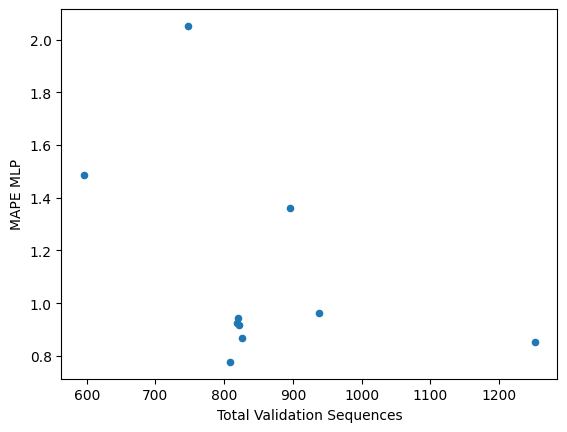

In [29]:
import pandas as pd

# Data for the DataFrame
data = {
    "DMA": ["DMA A", "DMA B", "DMA C", "DMA D", "DMA E", "DMA F", "DMA G", "DMA H", "DMA I", "DMA J"],
    "Training Split 1": [674, 895, 2471, 430, 769, 205, 748, 737, 380, 753],
    "Training Split 2": [653, 797, 1513, 380, 470, 273, 318, 681, 608, 664],
    "Training Split 3": [1513, 1513, 1513, 1513, 1513, 1009, 1001, 1513, 1513, 1513],
    "Training Split 4": [1513, 1513, 1513, 1513, 1513, 1129, 1513, 1469, 1513, 1171],
    "Training Split 5": [96, 96, 96, 96, 96, 60, 96, 96, 96, 96],
    "Total Training Sequences": [4449, 4814, 7106, 3932, 4361, 2676, 3676, 4496, 4110, 4197],
    "Validation Split 1": [120, 126, 313, 122, 196, 120, 121, 122, 239, 122],
    "Validation Split 2": [62, 74, 313, 72, 74, 73, 0, 74, 73, 73],
    "Validation Split 3": [313, 313, 313, 313, 313, 313, 313, 313, 313, 313],
    "Validation Split 4": [313, 313, 313, 313, 313, 313, 313, 87, 313, 313],
    "Total Validation Sequences": [808, 826, 1252, 820, 896, 819, 747, 596, 938, 821],
    "Test Split": [5145, 4161, 4812, 1764, 4839, 4444, 2933, 6744, 6578, 3992]
}

# Creating the DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
df.index = DMAs

df_val_splits_vs_pred = df[['Total Validation Sequences']].T.astype(float)
df_val_splits_vs_pred.loc['MAPE MLP'] = df_RMAE_test.iloc[0].loc[DMAs]
df_val_splits_vs_pred.T.plot.scatter(x='Total Validation Sequences', y='MAPE MLP')

/tmp/ipykernel_20573/1790953369.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/1790953369.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/1790953369.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/1790953369.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/1790953369.py:37: UserWarni

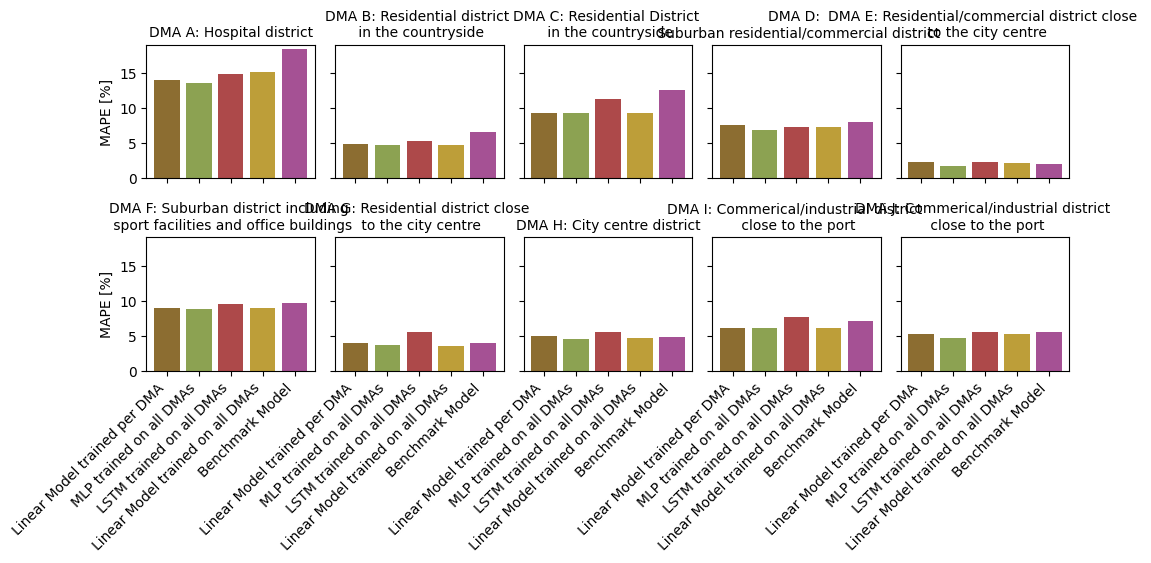

In [30]:

cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)
# colors_custom_order

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors_gen = ['tab:brown', 'tab:pink', 'tab:gray']*3
# colors_gen[-1] = 'tab:purple'
# colors_gen = np.array(colors_gen)

for i, ax in enumerate(axs):

    mape = df_MAPE_test.iloc[:,i].iloc[interesting_models_mape]
    ax.bar(mape.index, mape, color=colors_gen[interesting_models_mape])


    # ax.axhline(1, color='black', linestyle='--')
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    ax.set_ylim(0, 19)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('MAPE [%]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)


fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_MAPE_test.iloc[:,i].iloc[interesting_models_mape]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)


/tmp/ipykernel_20573/1893189532.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)


(0.0, 16.5)

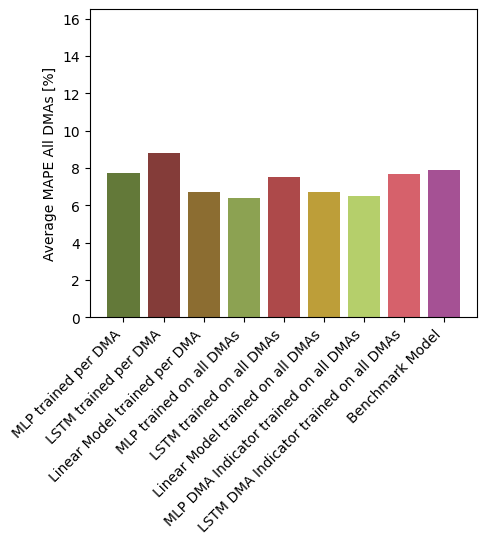

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
mape = df_MAPE_test['Average']
ax.bar(mape.index, mape, color=colors_gen)
# ax.axhline(1, color='black', linestyle='--')
ax.set_ylabel('Average MAPE All DMAs [%]')
ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0,16.5)

/tmp/ipykernel_20573/3777549903.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/3777549903.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/3777549903.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/3777549903.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_20573/3777549903.py:35: UserWarni

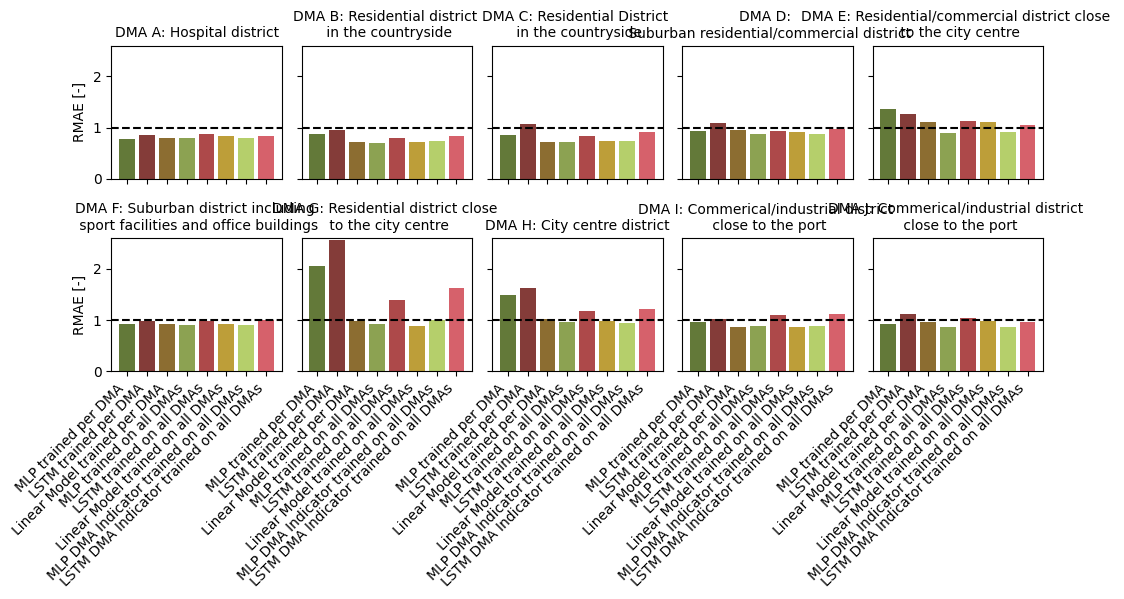

In [32]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# interesting_models = [0,1,2,3,4,5,6,7,8]

cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)

for i, ax in enumerate(axs):

    mape = df_RMAE_test.iloc[:,i]
    ax.bar(mape.index, mape, color=colors_gen)


    ax.axhline(1, color='black', linestyle='--')
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    ax.set_ylim(0, 2.6)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('RMAE [-]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
# add legend in th ebottom

# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_MAPE_test.iloc[:,i]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)



/tmp/ipykernel_20573/4196187492.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)


(0.0, 1.5)

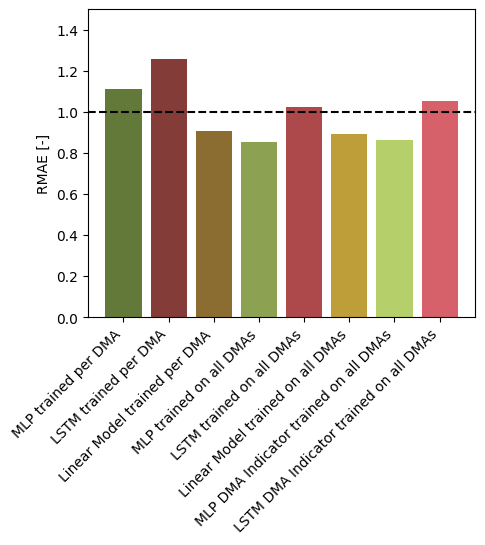

In [33]:
fig, ax = plt.subplots(figsize=(5,4))
mape = df_RMAE_test['Average']
ax.bar(mape.index, mape, color=colors_gen)
ax.axhline(1, color='black', linestyle='--')
ax.set_ylabel('RMAE [-]')
ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0,1.5)

/tmp/ipykernel_20573/4029055632.py:19: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/4029055632.py:19: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/4029055632.py:19: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/4029055632.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. Thes

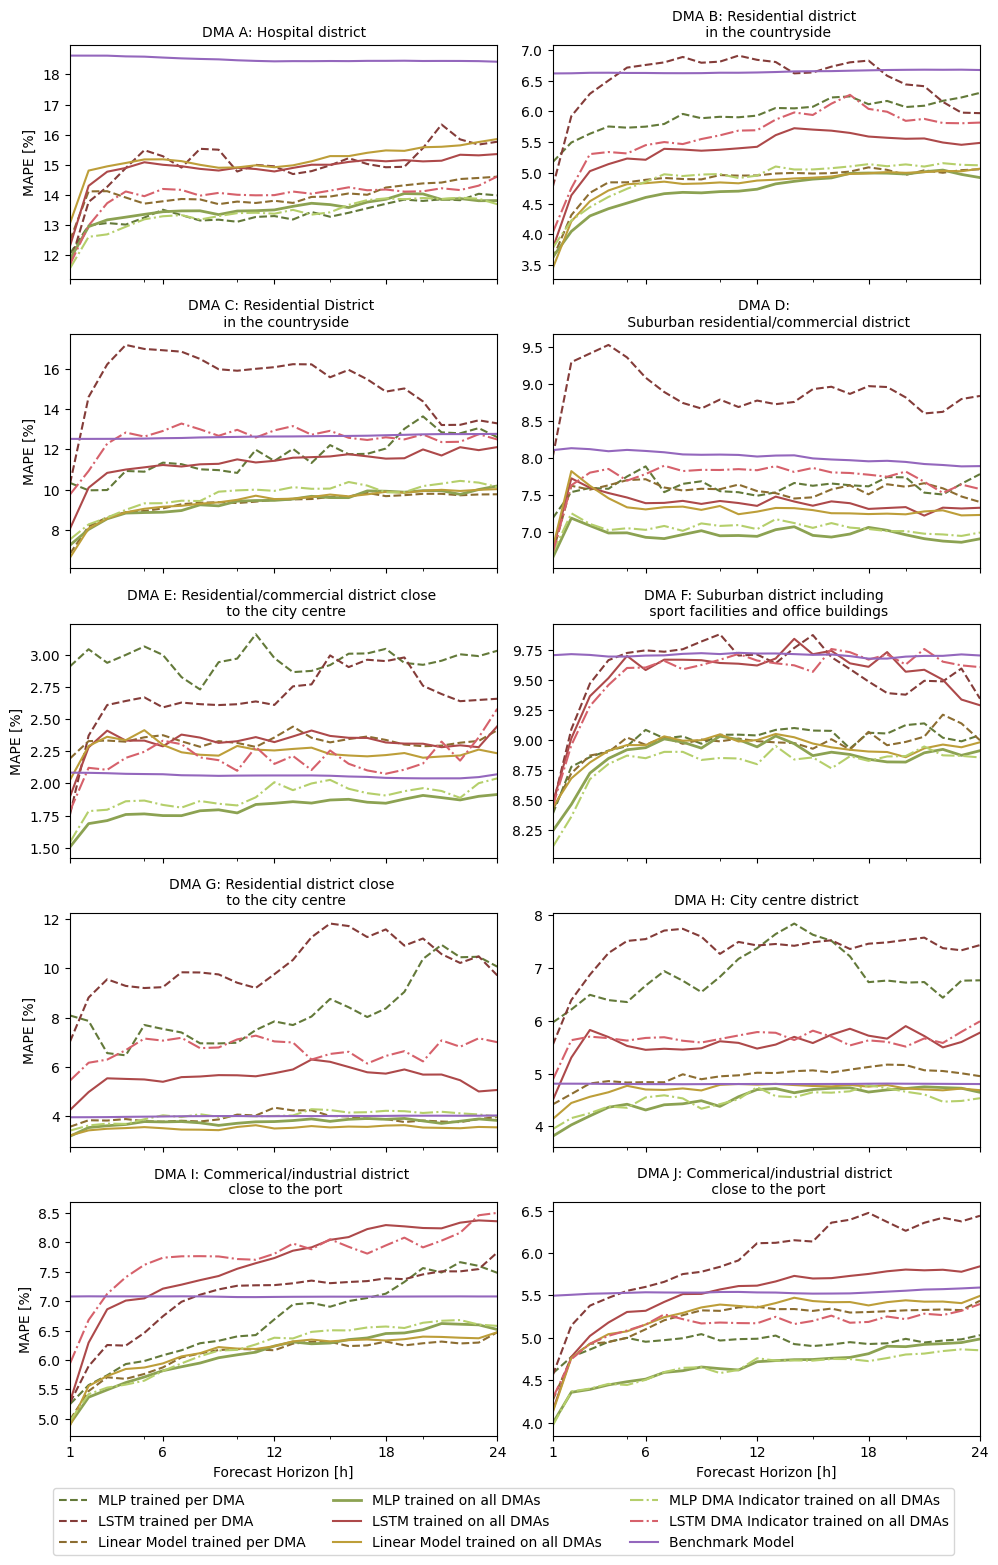

In [76]:
fig, ax = plt.subplots(5,2, figsize=(10, 15), sharex=True, sharey=False)#, sharex=True, sharey=True)

axs = ax.flatten()
# interesting_models = [0,1,2,3,4,5,6,7,8]

cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)
colors = colors_gen
linestyles = ['dashed', 'solid', 'dashdot']
linestyles = [linestyle for linestyle in linestyles for _ in range(3)]

for i, df in enumerate(dfs_test_results_MAPE_2d):
    if i == 3:
        df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=2, linestyle=linestyles[i], sharex=True, sharey=False)
    else:
        df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
df_result_2d_MAPE_naive_test.plot(subplots=True, ax=axs, legend=False, color='tab:purple', linewidth=1.5, sharey=False, sharex=True)

    # add new column names
for i, ax in enumerate(axs):
    ax.set_xticks([1, 6, 12, 18, 24])
    ax.set_xlim(1,24)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    if i%2==0:
        ax.set_ylabel('MAPE [%]')

    ax.set_xlabel('Forecast Horizon [h]')
    # ax.set_ylim(0, 1000)
    # ax.legend(['Model', 'Naive'])
    # ax.grid()


# add a legend iwth the model names
legend = fig.legend(list(modelnames)+['Benchmark Model'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.045))

fig.tight_layout()
plt.savefig('../figures/MAPE_point_forecasts_deterministic_models_all.png', bbox_extra_artists=[legend], bbox_inches='tight')

# plt.subplots_adjust(wspace=0.25)
# change 

/tmp/ipykernel_20573/2661552052.py:23: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/2661552052.py:21: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=2, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/2661552052.py:23: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
/tmp/ipykernel_20573/2661552052.py:23: UserWarning: When passing multiple axes, sharex and sharey are ignored. These 

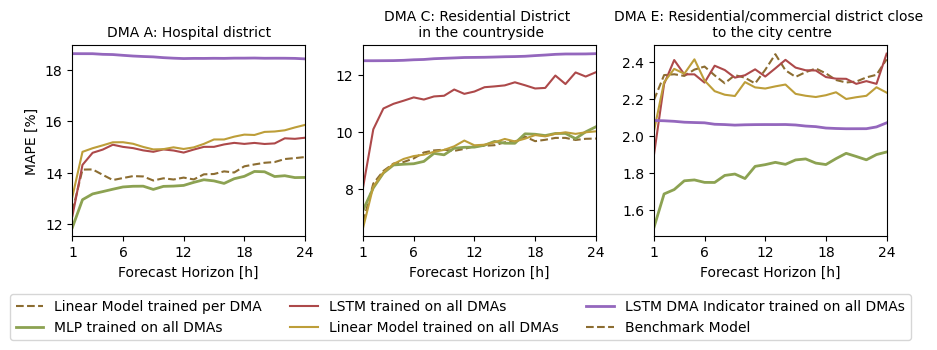

In [74]:
fig, ax = plt.subplots(1,3, figsize=(9, 3), sharex=True, sharey=False)#, sharex=True, sharey=True)

axs = ax.flatten()
# interesting_models = [0,1,2,3,4,5,6,7,8]

cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)
colors = colors_gen
linestyles = ['dashed', 'solid', 'dashdot']
linestyles = [linestyle for linestyle in linestyles for _ in range(3)]
DMA_selection = ['A', 'C', 'E']
DMA_selection_i = [0, 2, 4]
for i, df in enumerate(dfs_test_results_MAPE_2d):
    df = df.loc[:,DMA_selection]
    if i not in interesting_models_mape:
        continue
    if i == 3:
        df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=2, linestyle=linestyles[i], sharex=True, sharey=False)
    else:
        df.plot(subplots=True, ax=axs, legend=False, color=colors[i], linewidth=1.5, linestyle=linestyles[i], sharex=True, sharey=False)
df_result_2d_MAPE_naive_test.loc[:,DMA_selection].plot(subplots=True, ax=axs, legend=False, color='tab:purple', linewidth=1.5, sharey=False, sharex=True)

    # add new column names
for i, ax in enumerate(axs):
    ax.set_xticks([1, 6, 12, 18, 24])
    ax.set_xlim(1,24)
    ax.set_title(np.array(new_column_names_with_newlines)[DMA_selection_i][i], fontsize=10)
    if i==0 or i==5:
        ax.set_ylabel('MAPE [%]')

    ax.set_xlabel('Forecast Horizon [h]')
    # ax.set_ylim(0, 1000)
    # ax.legend(['Model', 'Naive'])
    # ax.grid()


# add a legend iwth the model names
legend = fig.legend(list(modelnames[interesting_models_rmae])+['Benchmark Model'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.175))

fig.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('../figures/MAPE_point_forecasts_deterministic_models_subset.png', bbox_extra_artists=[legend], bbox_inches='tight')
# change 

,A,B,C,D,E,F,G,H,I,J
1,18.622684,6.618856,12.519458,8.104794,2.084201,9.705889,3.960223,4.807724,7.079044,5.496809
2,18.622017,6.621277,12.519130,8.130952,2.082780,9.714714,3.962347,4.807590,7.081845,5.507800
3,18.621197,6.629434,12.521000,8.117842,2.079823,9.708104,3.966329,4.806679,7.080335,5.519888
4,18.597082,6.630369,12.523720,8.089679,2.075017,9.694468,3.976914,4.803154,7.080986,5.524793
5,18.588003,6.626784,12.534195,8.107737,2.073211,9.694500,3.983931,4.801750,7.080266,5.530715
6,18.558264,6.626621,12.553165,8.093495,2.071696,9.702627,3.991433,4.799491,7.080054,5.537313
7,18.531199,6.623387,12.563981,8.075531,2.063921,9.704496,4.001573,4.798998,7.081695,5.534962
8,18.512287,6.622715,12.590740,8.046522,2.062183,9.717045,4.004553,4.797161,7.080438,5.533630
9,18.498158,6.623868,12.604734,8.041504,2.059187,9.722721,4.008391,4.798912,7.075442,5.532919
10,18.467733,6.630509,12.618054,8.044247,2.061042,9.715267,4.009707,4.801398,7.069115,5.540646


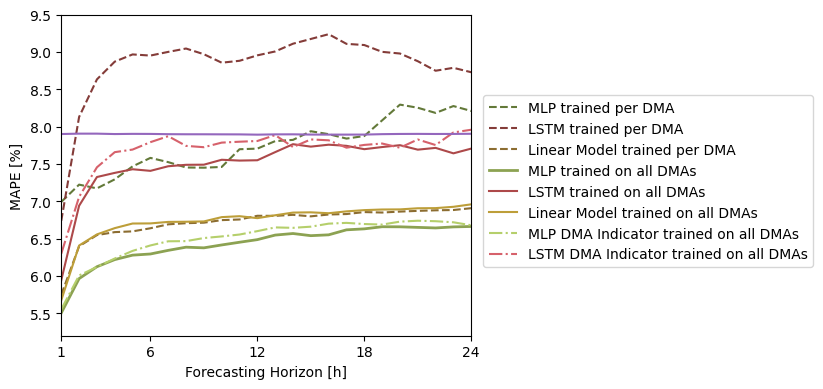

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=True)
# axs = ax.flatten()
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)
colors = colors_gen

[ax.plot(dfs_test_results_MAPE_2d[i].mean(axis=1), color=colors[i], linestyle=linestyles[i], linewidth=2 if i==3 else 1.5) for i in range(len(modelnames))]
df_result_2d_MAPE_naive_test.mean(axis=1).plot(subplots=True, ax=ax, legend=False, color='tab:purple', linewidth=1.5, sharey=False, sharex=True)

# ax.plot(QR_result_mape_2d_test.mean(axis=1), color=colors[0])
# ax.plot(MDN_result_mape_2d_test.mean(axis=1), color=colors[1])
# ax.plot(MCD_result_mape_2d_test.mean(axis=1), color=colors[2])
# ax.plot(CQR_result_mape_2d_test.mean(axis=1), color=colors[3])    
# ax.plot(MLP_all_dmas_mape_2d_test.mean(axis=1), color=colors[4], linewidth=3)
# ax.plot(LD_per_dma_mape_2d_test.mean(axis=1), color=colors[5], linestyle='dashdot')
# ax.plot(LD_all_dmas_mape_2d_test.mean(axis=1), color=colors[6])
# ax.plot(NAIVE_all_dmas_mape_2d_test.mean(axis=1), color=colors[7])

# ax.set_title('Average MAPE [-] over the forecasting horizon', fontsize=10)
# ax.legend()
ax.set_xticks([1,6,12,18,24])
ax.set_ylim(5.2,9.5)
ax.set_xlim(1,24)
ax.set_xlabel('Forecasting Horizon [h]')
# if i==0 or i==5:
ax.set_ylabel('MAPE [%]')
# add legend in th ebottom
legend = fig.legend(modelnames,
            loc='lower right', ncol=1, bbox_to_anchor=(1.65, 0.3))
fig.tight_layout()
plt.savefig('../figures/MAPE_point_forecasts_deterministic_models_avg.png', bbox_extra_artists=[legend], bbox_inches='tight')


/tmp/ipykernel_15260/386285098.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/386285098.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/386285098.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/386285098.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/386285098.py:28

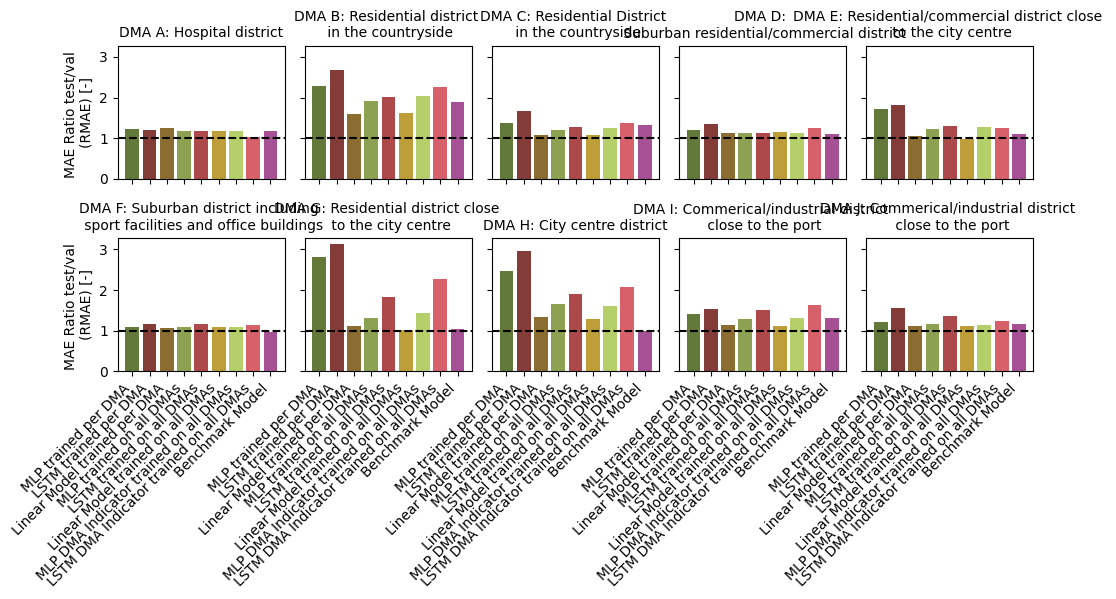

In [56]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors_gen = ['tab:brown', 'tab:pink', 'tab:gray']*3
# colors_gen[-1] = 'tab:purple'
linestyles = ['dashed', 'solid', 'dashdot']
linestyles = [linestyle for linestyle in linestyles for _ in range(3)]
for i, ax in enumerate(axs):

    mean_gen = df_mae_gen.iloc[:,i]
    ax.bar(mean_gen.index, mean_gen, color=colors_gen)


    ax.axhline(1, color='black', linestyle='--')
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('MAE Ratio test/val \n(RMAE) [-]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
# add legend in th ebottom

# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mean_gen = df_mae_gen.iloc[:,i]
    
    ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)




/tmp/ipykernel_15260/3206497535.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)


(0.0, 3.0)

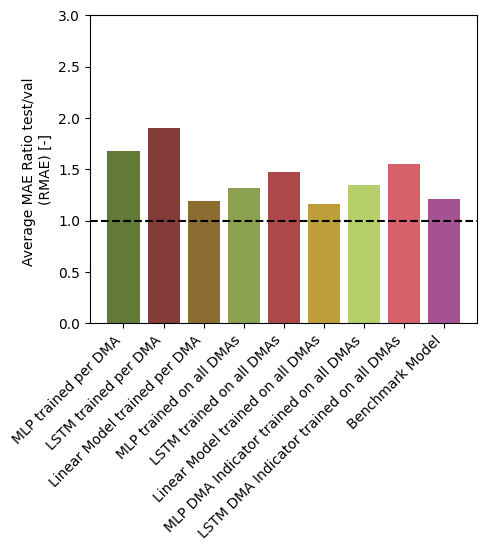

In [57]:
fig, ax = plt.subplots(figsize=(5,4))
mean_gen = df_mae_gen['Average']
ax.bar(mean_gen.index, mean_gen, color=colors_gen)
ax.axhline(1, color='black', linestyle='--')
ax.set_ylabel('Average MAE Ratio test/val \n(RMAE) [-]')
ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0,3)

In [34]:
ds = '24h_out_all_no_weather'
data_folder = '../data/sequences/'


naive_val = [torch.load(os.path.join(data_folder, ds,'val_naive_final_{}_{}.pt'.format(ds, dma)), map_location='cpu') for dma in ['A']]

# Point forecasts probabilistic models                                  

In [60]:
# from now we analyze the probabilistic forecasts
project_list_QR = [
    '00_MLP_QR_rpb_FINAL99'
]

project_list_MDN = [
    '00_MLP_MDN_FINAL99',
]


def get_run(rundir, results_folder, download=False):
    # Set up the results folder for the project
    results_project_folder = os.path.join(results_folder, rundir.split('/')[1])
    if not os.path.exists(results_project_folder):
        os.makedirs(results_project_folder)

    api = wandb.Api()
    run = api.run(rundir)
    
    if download:
        for f in run.files():
            f.download(replace=True, root=results_project_folder)
    info = {**run.config, **run.summary}
    return info
    

# DMA A to J
# DMAs = ['DMA A (L/s)', 'DMA B (L/s)', 'DMA C (L/s)', 'DMA D (L/s)', 'DMA E (L/s)', 'DMA F (L/s)', 'DMA G (L/s)', 'DMA H (L/s)', 'DMA I (L/s)', 'DMA J (L/s)']
results_folder = 'results'

# uncomment to download best runs from wandb

# for project in project_list_QR:
#     get_best_run_info_from_last_sweep(project, results_folder, download=True)
# for project in project_list_MDN:
#     get_best_run_info_from_last_sweep(project, results_folder, download=True)

# get results
result_dict_mdn_2 = get_results_prob(project_list_MDN[0], MLP)
result_dict_qr_2 = get_results_prob(project_list_QR[0], MLP)



In [61]:
# get the results of the models mcd and cqr 
mcd_pt_test = torch.load('../show_results/results/TESTING_MLP_MCD_VAL2/results.pt')
mlp_cp = torch.load(f'../show_results/results/MLP_CP_FINAL3/cp_results_final.pt') # CQR results
MLP_results = get_results_pt_dma_together('00__MLP_Vanilla_DMA_ALL2', MLP) 

# get the Lineardropout results of the model that was trained per DMA
LD_per_dma_results = get_results_pt_model_per_dma('00_LD_Vanilla_PER_DMA_FINAL', LinearDropout)
LD_all_dmas_results = get_results_pt_dma_together('00_Final_LD_Vanilla_ALL2', LinearDropout)

In [62]:
DMAs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

# Reorder colors based on the custom order
colors_gen = cmaptab20b(custom_order)

In [63]:
# get the 2d results of all the above models

LD_per_dma_mape_2d_test = LD_per_dma_results['test']['results_2d_MAPE']
LD_per_dma_rmae_2d_test = LD_per_dma_results['test']['results_2d_RMAE']
LD_per_dma_mae_2d_test = LD_per_dma_results['test']['results_2d_mae']
LD_per_dma_mape_2d_val = LD_per_dma_results['val']['results_2d_MAPE']
LD_per_dma_rmae_2d_val = LD_per_dma_results['val']['results_2d_RMAE']
LD_per_dma_mae_2d_val = LD_per_dma_results['val']['results_2d_mae']

LD_all_dmas_mape_2d_test = LD_all_dmas_results['test']['results_2d_MAPE']
LD_all_dmas_rmae_2d_test = LD_all_dmas_results['test']['results_2d_RMAE']
LD_all_dmas_mae_2d_test = LD_all_dmas_results['test']['results_2d_mae']
LD_all_dmas_mape_2d_val = LD_all_dmas_results['val']['results_2d_MAPE']
LD_all_dmas_rmae_2d_val = LD_all_dmas_results['val']['results_2d_RMAE']
LD_all_dmas_mae_2d_val = LD_all_dmas_results['val']['results_2d_mae']

MLP_all_dmas_mape_2d_test = MLP_results['test']['results_2d_MAPE']
MLP_all_dmas_rmae_2d_test = MLP_results['test']['results_2d_RMAE']
MLP_all_dmas_mae_2d_test = MLP_results['test']['results_2d_mae']
MLP_all_dmas_mape_2d_val = MLP_results['val']['results_2d_MAPE']
MLP_all_dmas_rmae_2d_val = MLP_results['val']['results_2d_RMAE']
MLP_all_dmas_mae_2d_val = MLP_results['val']['results_2d_mae']

QR_result_mape_2d_test = result_dict_qr_2['test']['2d_MAPE']
QR_result_rmae_2d_test = result_dict_qr_2['test']['2d_RMAE']
QR_result_mae_2d_test = result_dict_qr_2['test']['2d_mae']
QR_result_mape_2d_val = result_dict_qr_2['val']['2d_MAPE']
QR_result_rmae_2d_val = result_dict_qr_2['val']['2d_RMAE']
QR_result_mae_2d_val = result_dict_qr_2['val']['2d_mae']

MDN_result_mape_2d_test = result_dict_mdn_2['test']['2d_MAPE']
MDN_result_rmae_2d_test = result_dict_mdn_2['test']['2d_RMAE']
MDN_result_mae_2d_test = result_dict_mdn_2['test']['2d_mae']
MDN_result_mape_2d_val = result_dict_mdn_2['val']['2d_MAPE']
MDN_result_rmae_2d_val = result_dict_mdn_2['val']['2d_RMAE']
MDN_result_mae_2d_val = result_dict_mdn_2['val']['2d_mae']

MCD_result_mape_2d_test = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_MAPE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_mape_2d_test.index = MCD_result_mape_2d_test.index + 1
MCD_result_mape_2d_test.columns = DMAs
MCD_result_rmae_2d_test = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_RMAE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_rmae_2d_test.index = MCD_result_mape_2d_test.index + 1
MCD_result_rmae_2d_test.columns = DMAs
MCD_result_mae_2d_test = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_test_MAE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_mae_2d_test.index = MCD_result_mape_2d_test.index + 1
MCD_result_mae_2d_test.columns = DMAs

MCD_result_mape_2d_val = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_MAPE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_mape_2d_val.index = MCD_result_mape_2d_test.index + 1
MCD_result_mape_2d_val.columns = DMAs
MCD_result_rmae_2d_val = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_RMAE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_rmae_2d_val.index = MCD_result_mape_2d_test.index + 1
MCD_result_rmae_2d_val.columns = DMAs
MCD_result_mae_2d_val = pd.concat([pd.Series(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics_2d'][f'TESTING_MLP_MCD_VAL2_{dma}_val_MAE_2d'].numpy()) for dma in DMAs], axis=1)
MCD_result_mae_2d_val.index = MCD_result_mape_2d_test.index + 1
MCD_result_mae_2d_val.columns = DMAs

CQR_result_mape_2d_test = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['test']['MAPE_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_mape_2d_test.index = CQR_result_mape_2d_test.index + 1
CQR_result_mape_2d_test.columns = DMAs
CQR_result_rmae_2d_test = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['test']['RMAE_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_rmae_2d_test.index = CQR_result_mape_2d_test.index + 1
CQR_result_rmae_2d_test.columns = DMAs
CQR_result_mae_2d_test = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['test']['mae_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_mae_2d_test.index = CQR_result_mape_2d_test.index + 1
CQR_result_mae_2d_test.columns = DMAs

CQR_result_mape_2d_val = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['val']['MAPE_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_mape_2d_val.index = CQR_result_mape_2d_test.index + 1
CQR_result_mape_2d_val.columns = DMAs
CQR_result_rmae_2d_val = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['val']['RMAE_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_rmae_2d_val.index = CQR_result_mape_2d_test.index + 1
CQR_result_rmae_2d_val.columns = DMAs
CQR_result_mae_2d_val = pd.concat([pd.concat([pd.Series(mlp_cp[dma]['val']['mae_2d'].numpy()) for dma in DMAs], axis=1)])
CQR_result_mae_2d_val.index = CQR_result_mape_2d_test.index + 1
CQR_result_mae_2d_val.columns = DMAs

NAIVE_all_dmas_mape_2d_test = MLP_results['test']['results_2d_MAPE_naive']
NAIVE_all_dmas_mape_2d_val = MLP_results['val']['results_2d_MAPE_naive']
NAIVE_all_dmas_mae_2d_test = MLP_results['test']['results_2d_mae_naive']
NAIVE_all_dmas_mae_2d_val = MLP_results['val']['results_2d_mae_naive']

# 1d metrics
# linear models
LD_per_dma_results_test_pt = LD_per_dma_results['test']['results']
LD_per_dma_results_test_pt['Average'] = LD_per_dma_results_test_pt.mean(axis=1)
LD_all_dmas_results_test_pt = LD_all_dmas_results['test']['results']
LD_all_dmas_results_test_pt['Average'] = LD_all_dmas_results_test_pt.mean(axis=1)
LD_per_dma_results_val_pt = LD_per_dma_results['val']['results']
LD_per_dma_results_val_pt['Average'] = LD_per_dma_results_val_pt.mean(axis=1)
LD_all_dmas_results_val_pt = LD_all_dmas_results['val']['results']
LD_all_dmas_results_val_pt['Average'] = LD_all_dmas_results_val_pt.mean(axis=1)

# MLP
MLP_results_test_pt = MLP_results['test']['results']
MLP_results_test_pt['Average'] = MLP_results_test_pt.mean(axis=1)
MLP_results_val_pt = MLP_results['val']['results']
MLP_results_val_pt['Average'] = MLP_results_val_pt.mean(axis=1)

# QR
QR_result_test_pt = result_dict_qr_2['test']['1d_metrics']
QR_result_val_pt = result_dict_qr_2['val']['1d_metrics']

# MDN 
MDN_result_test_pt = result_dict_mdn_2['test']['1d_metrics']
MDN_result_val_pt = result_dict_mdn_2['val']['1d_metrics']

# MCD
index_mcd_cqr = ['Loss', 'MAE',         'RMAE',         'MAPE', 
                     'Lowest AE',  'Lowest APE',  'Lowest RAE', 
                     'Highest AE', 'Highest APE', 'Highest RAE', 
                     'Median AE',  'Median APE',  'Median RAE']
mcd_test_pt = pd.concat([pd.DataFrame(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_test']['metrics'].values(), index=index_mcd_cqr, columns=[dma]) for dma in DMAs], axis=1).iloc[1:,:]
mcd_val_pt = pd.concat([pd.DataFrame(mcd_pt_test[f'TESTING_MLP_MCD_VAL2_{dma}_val']['metrics'].values(), index=index_mcd_cqr, columns=[dma]) for dma in DMAs], axis=1).iloc[1:,:]
mcd_test_pt['Average'] = mcd_test_pt.mean(axis=1)
mcd_val_pt['Average'] = mcd_val_pt.mean(axis=1)

CP_KEYS = ['mae_1d', 'RMAE_1d', 'MAPE_1d', 'lowest_AE', 'lowest_APE', 'lowest_RAE', 'highest_AE', 'highest_APE', 'highest_RAE', 'median_AE', 'median_APE', 'median_RAE']

# CQR
test_cqr_mae = [mlp_cp[dma]['test'][CP_KEYS[0]].numpy() for dma in DMAs]
test_cqr_rmae = [mlp_cp[dma]['test'][CP_KEYS[1]].numpy() for dma in DMAs]
test_cqr_mape = [mlp_cp[dma]['test'][CP_KEYS[2]].numpy() for dma in DMAs]
test_cqr_MinAE = [mlp_cp[dma]['test'][CP_KEYS[3]].numpy() for dma in DMAs]
test_cqr_MinAPE = [mlp_cp[dma]['test'][CP_KEYS[4]].numpy() for dma in DMAs]
test_cqr_MinRAE = [mlp_cp[dma]['test'][CP_KEYS[5]].numpy() for dma in DMAs]
test_cqr_MaxAE = [mlp_cp[dma]['test'][CP_KEYS[6]].numpy() for dma in DMAs]
test_cqr_MaxAPE = [mlp_cp[dma]['test'][CP_KEYS[7]].numpy() for dma in DMAs]
test_cqr_MaxRAE = [mlp_cp[dma]['test'][CP_KEYS[8]].numpy() for dma in DMAs]
test_cqr_MedAE = [mlp_cp[dma]['test'][CP_KEYS[9]].numpy() for dma in DMAs]
test_cqr_MedAPE = [mlp_cp[dma]['test'][CP_KEYS[10]].numpy() for dma in DMAs]
test_cqr_MedRAE = [mlp_cp[dma]['test'][CP_KEYS[11]].numpy() for dma in DMAs]

cqr_test_pt = pd.DataFrame([test_cqr_mae, test_cqr_rmae, test_cqr_mape, 
                            test_cqr_MinAE, test_cqr_MinAPE, test_cqr_MinRAE, 
                            test_cqr_MaxAE, test_cqr_MaxAPE, test_cqr_MaxRAE, 
                            test_cqr_MedAE, test_cqr_MedAPE, test_cqr_MedRAE], index=index_mcd_cqr[1:], columns=DMAs)

val_cqr_mae = [mlp_cp[dma]['val'][CP_KEYS[0]].numpy() for dma in DMAs]
val_cqr_rmae = [mlp_cp[dma]['val'][CP_KEYS[1]].numpy() for dma in DMAs]
val_cqr_mape = [mlp_cp[dma]['val'][CP_KEYS[2]].numpy() for dma in DMAs]
cqr_val_pt = pd.DataFrame([val_cqr_mae, val_cqr_rmae, val_cqr_mape], index=index_mcd_cqr[1:4], columns=DMAs)
cqr_test_pt['Average'] = cqr_test_pt.mean(axis=1)
cqr_val_pt['Average'] = cqr_val_pt.mean(axis=1)

# NAIVE
test_naive_mae = NAIVE_all_dmas_mae_2d_test.mean(axis=0).to_list()
test_naive_mape = NAIVE_all_dmas_mape_2d_test.mean(axis=0).to_list()
test_naive_rmae = [1]*10
naive_test_pt = pd.DataFrame([test_naive_mae, test_naive_rmae, test_naive_mape], index=['MAE', 'RMAE', 'MAPE'], columns=DMAs)
naive_test_pt['Average'] = naive_test_pt.mean(axis=1)
val_naive_mae = NAIVE_all_dmas_mae_2d_val.mean(axis=0).to_list()
val_naive_mape = NAIVE_all_dmas_mape_2d_val.mean(axis=0).to_list()
val_naive_rmae = [1]*10
naive_val_pt = pd.DataFrame([val_naive_mae, val_naive_rmae, val_naive_mape], index=['MAE', 'RMAE', 'MAPE'], columns=DMAs)
naive_val_pt['Average'] = naive_val_pt.mean(axis=1)

# Turn into a dataframe
df_mae_gen_1d = pd.DataFrame()
models_bar = ['QR', 
             'MDN', 
             'MCD', 
             'CQR', 
             'MLP*',
             'Linear model trained per DMA*',
             'Linear model trained on all DMAs*',
             'Benchmark',
            ]

# get the average of the test/val ratio (generalization Score)
for i, dma in enumerate(DMAs):
    mean_gen = [(     QR_result_mae_2d_test.iloc[:,i].mean()/         QR_result_mae_2d_val.iloc[:,i].mean()),
                (    MDN_result_mae_2d_test.iloc[:,i].mean()/        MDN_result_mae_2d_val.iloc[:,i].mean()),
                (    MCD_result_mae_2d_test.iloc[:,i].mean()/        MCD_result_mae_2d_val.iloc[:,i].mean()),
                (    CQR_result_mae_2d_test.iloc[:,i].mean()/        CQR_result_mae_2d_val.iloc[:,i].mean()),
                (  MLP_all_dmas_mae_2d_test.iloc[:,i].mean()/      MLP_all_dmas_mae_2d_val.iloc[:,i].mean()),
                (    LD_per_dma_mae_2d_test.iloc[:,i].mean()/        LD_per_dma_mae_2d_val.iloc[:,i].mean()),
                (   LD_all_dmas_mae_2d_test.iloc[:,i].mean()/       LD_all_dmas_mae_2d_val.iloc[:,i].mean()),
                (NAIVE_all_dmas_mae_2d_test.iloc[:,i].mean()/    NAIVE_all_dmas_mae_2d_val.iloc[:,i].mean()),
                ]
    
    df_mae_gen_1d[dma] = mean_gen
df_mae_gen_1d.index=models_bar
# df_mae_gen_1d = df_gen_mae_1
df_mae_gen_1d['Average'] = df_mae_gen_1d.mean(axis=1)

In [64]:
cmaptab20b = plt.get_cmap('tab20b')
custom_order = [4, 12, 8, 5, 13, 9, 6, 14, 17]

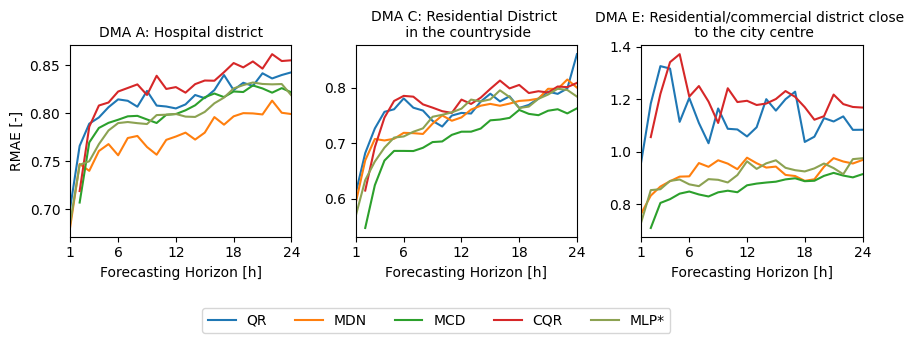

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3), sharex=True)
axs = ax.flatten()

deterministic_colors = list(cmaptab20b(custom_order)[[3,2,5]])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] + deterministic_colors
iis = [0,2,4]
for i, ax in enumerate(axs):
    i = iis[i]
    ax.plot(QR_result_rmae_2d_test.iloc[:,i]      , color=colors[0])
    ax.plot(MDN_result_rmae_2d_test.iloc[:,i]       , color=colors[1])
    ax.plot(MCD_result_rmae_2d_test.iloc[:,i]       , color=colors[2])
    ax.plot(CQR_result_rmae_2d_test.iloc[:,i ]    , color=colors[3])    
    ax.plot(MLP_all_dmas_rmae_2d_test.iloc[:,i]  , color=colors[4])
   
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend().
    ax.set_xticks([1,6,12,18,24])
    ax.set_xlim(1,24)
    ax.set_xlabel('Forecasting Horizon [h]')
    if i==0 or i==5:
        ax.set_ylabel('RMAE [-]')
# add legend in th ebottom
legend = fig.legend([           
     'QR', 
            'MDN', 
            'MCD', 
            'CQR', 
            'MLP*',
            ], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.15))
fig.tight_layout()
plt.savefig('../figures/RMAE_point_forecasts_probabilistic_models_subset.png', bbox_extra_artists=[legend], bbox_inches='tight')


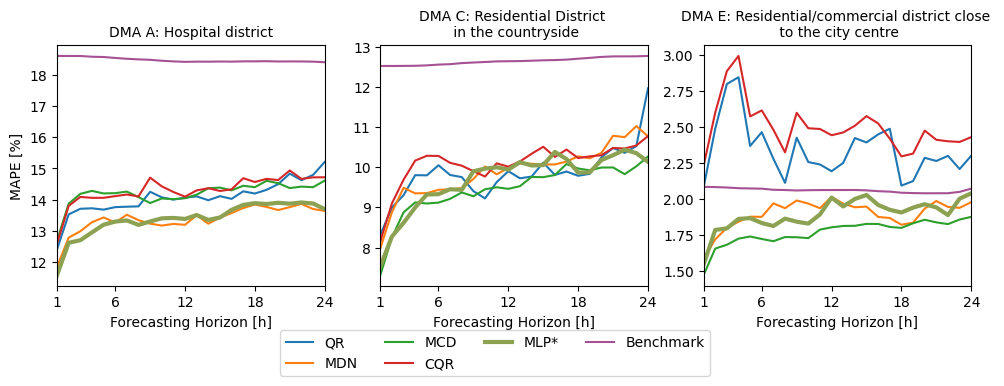

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3.5), sharex=True)
axs = ax.flatten()
iis = [0,2,4]
deterministic_colors = list(cmaptab20b(custom_order)[[3,2,5,-1]])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] + deterministic_colors

for i, ax in enumerate(axs):
    i = iis[i]
    ax.plot(QR_result_mape_2d_test.iloc[:,i], color=colors[0])
    ax.plot(MDN_result_mape_2d_test.iloc[:,i], color=colors[1])
    ax.plot(MCD_result_mape_2d_test.iloc[:,i], color=colors[2])
    ax.plot(CQR_result_mape_2d_test.iloc[:,i], color=colors[3])    
    ax.plot(MLP_all_dmas_mape_2d_test.iloc[:,i], color=colors[4], linewidth=3)
    # ax.plot(LD_per_dma_mape_2d_test.iloc[:,i], color=colors[5], linestyle='dashdot')
    # ax.plot(LD_all_dmas_mape_2d_test.iloc[:,i], color=colors[6])
    ax.plot(NAIVE_all_dmas_mape_2d_test.iloc[:,i], color=colors[-1])

    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    ax.set_xticks([1,6,12,18,24])
    ax.set_xlim(1,24)
    ax.set_xlabel('Forecasting Horizon [h]')
    if i==0 or i==5:
        ax.set_ylabel('MAPE [%]')
    # ax.grid()
# add legend in th ebottom
legend = fig.legend([            'QR', 
            'MDN', 
            'MCD', 
            'CQR', 
            'MLP*',
            'Benchmark',
            ], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.11))
fig.tight_layout()

plt.savefig('../figures/MAPE_point_forecasts_probabilistic_models_subset.png', bbox_extra_artists=[legend], bbox_inches='tight')


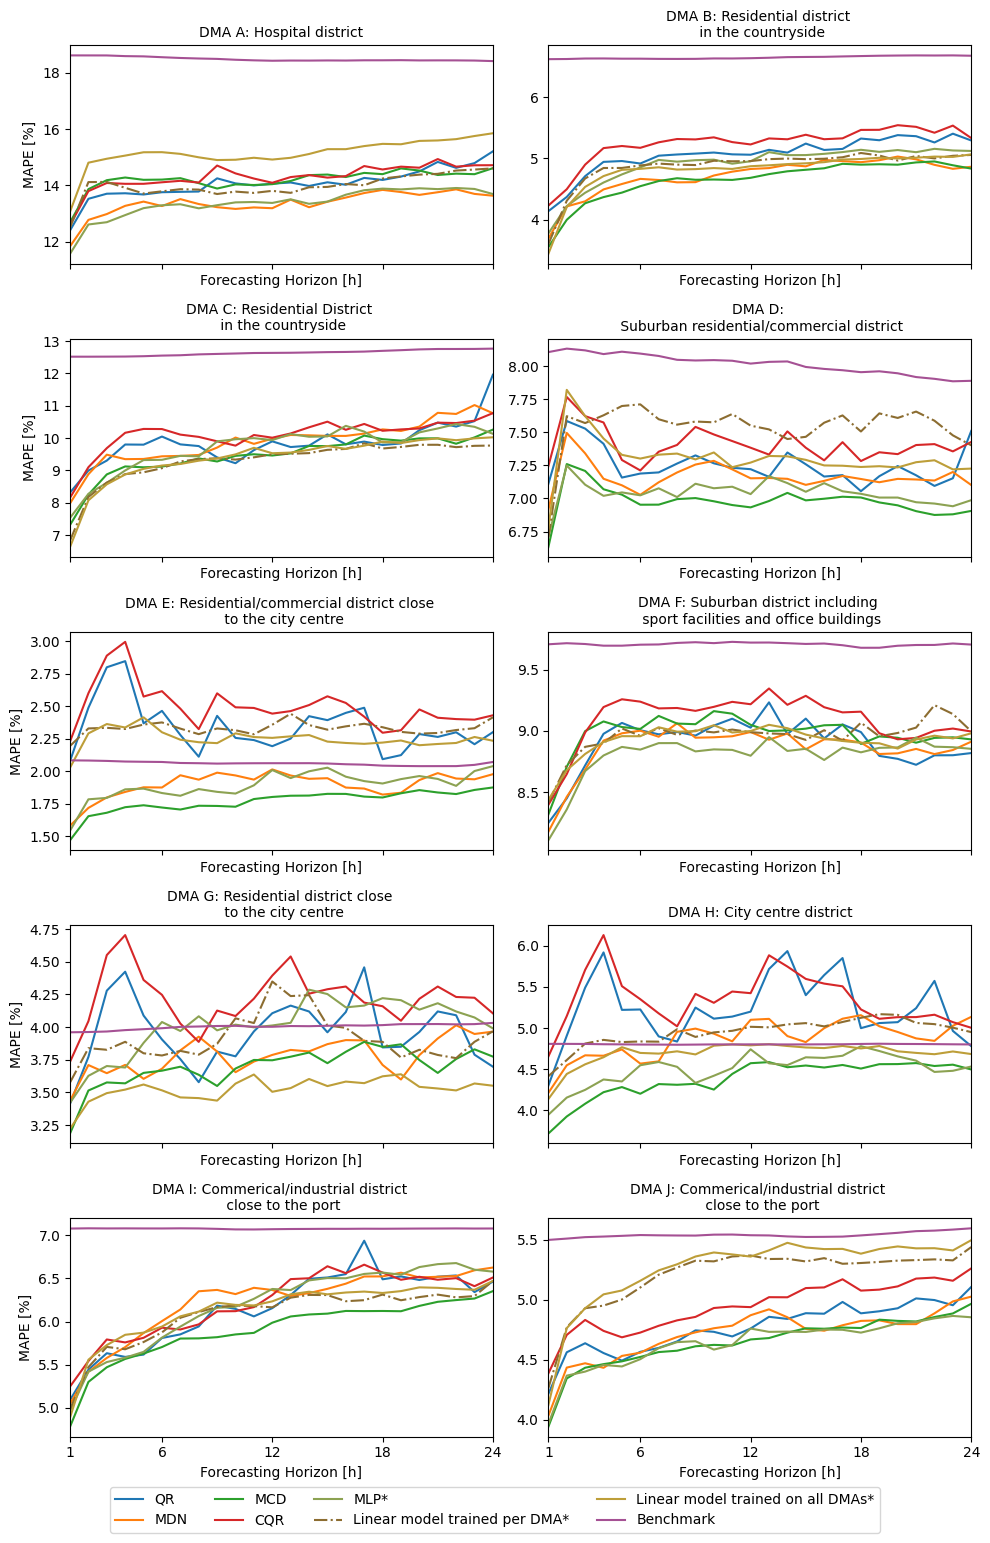

In [77]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=True)
axs = ax.flatten()
deterministic_colors = list(cmaptab20b(custom_order)[[3,2,5,-1]])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] + deterministic_colors
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
for i, ax in enumerate(axs):
    ax.plot(QR_result_mape_2d_test.iloc[:,i], color=colors[0])
    ax.plot(MDN_result_mape_2d_test.iloc[:,i], color=colors[1])
    ax.plot(MCD_result_mape_2d_test.iloc[:,i], color=colors[2])
    ax.plot(CQR_result_mape_2d_test.iloc[:,i], color=colors[3])    
    ax.plot(MLP_all_dmas_mape_2d_test.iloc[:,i], color=colors[4])
    ax.plot(LD_per_dma_mape_2d_test.iloc[:,i], color=colors[5], linestyle='dashdot')
    ax.plot(LD_all_dmas_mape_2d_test.iloc[:,i], color=colors[6])
    ax.plot(NAIVE_all_dmas_mape_2d_test.iloc[:,i], color='tab:purple')

    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    ax.set_xticks([1,6,12,18,24])
    ax.set_xlim(1,24)
    ax.set_xlabel('Forecasting Horizon [h]')
    if i%2==0:
        ax.set_ylabel('MAPE [%]')

legend=fig.legend(['QR', 
                   'MDN', 
                   'MCD', 
                   'CQR', 
                   'MLP*',
                   'Linear model trained per DMA*',
                   'Linear model trained on all DMAs*',
                   'Benchmark',
            ], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.03))
fig.tight_layout()
plt.savefig('../figures/MAPE_point_forecasts_probabilistic_models_all_forecasting_horizon.png', bbox_extra_artists=[legend], bbox_inches='tight')


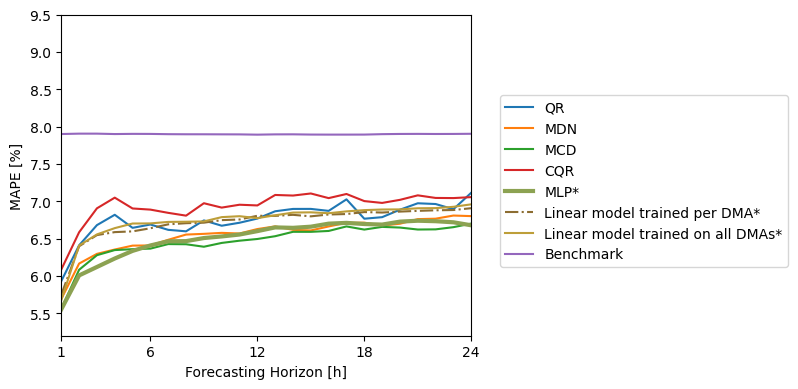

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=True)
# axs = ax.flatten()
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
deterministic_colors = list(cmaptab20b(custom_order)[[3,2,5,-1]])
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'] + deterministic_colors
ax.plot(QR_result_mape_2d_test.mean(axis=1), color=colors[0])
ax.plot(MDN_result_mape_2d_test.mean(axis=1), color=colors[1])
ax.plot(MCD_result_mape_2d_test.mean(axis=1), color=colors[2])
ax.plot(CQR_result_mape_2d_test.mean(axis=1), color=colors[3])    
ax.plot(MLP_all_dmas_mape_2d_test.mean(axis=1), color=colors[4], linewidth=3)
ax.plot(LD_per_dma_mape_2d_test.mean(axis=1), color=colors[5], linestyle='dashdot')
ax.plot(LD_all_dmas_mape_2d_test.mean(axis=1), color=colors[6])
ax.plot(NAIVE_all_dmas_mape_2d_test.mean(axis=1), color='tab:purple')

# ax.set_title('Average MAPE [-] over the forecasting horizon', fontsize=10)
# ax.legend()
ax.set_xticks([1,6,12,18,24])
ax.set_xlim(1,24)
ax.set_xlabel('Forecasting Horizon [h]')
# if i==0 or i==5:
ax.set_ylim(5.2,9.5)
ax.set_ylabel('MAPE [%]')
# add legend in th ebottom
legend = fig.legend([            'QR', 
            'MDN', 
            'MCD', 
            'CQR', 
            'MLP*',
            'Linear model trained per DMA*',
            'Linear model trained on all DMAs*',
            'Benchmark',
            ], loc='lower right', ncol=1, bbox_to_anchor=(1.6, 0.3))
fig.tight_layout()
plt.savefig('../figures/MAPE_point_forecasts_probabilistic_models_avg.png', bbox_extra_artists=[legend], bbox_inches='tight')


/tmp/ipykernel_15260/4256316320.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/4256316320.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/4256316320.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/4256316320.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_15260/4256316320.

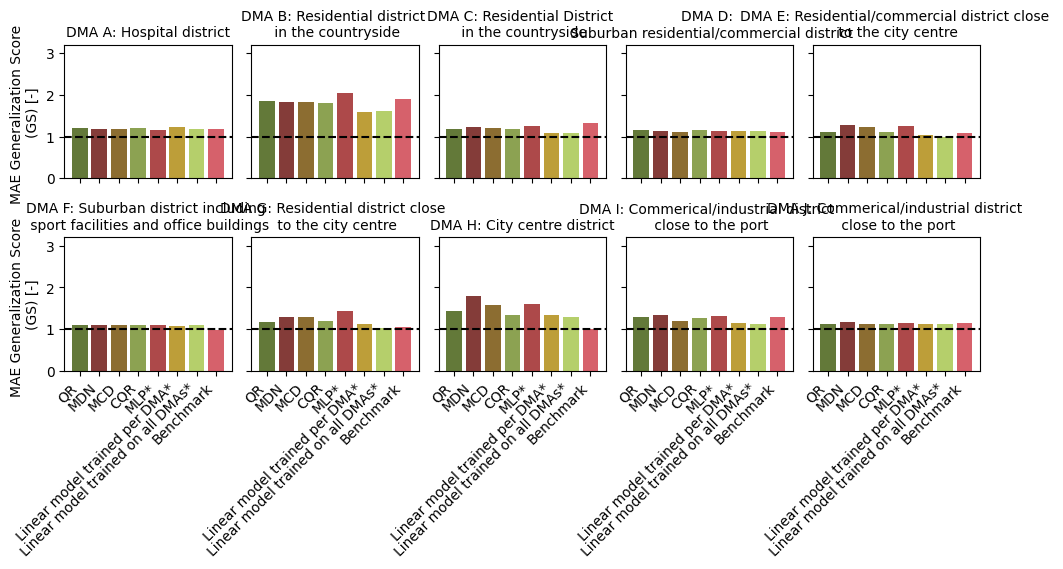

In [28]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors_gen = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
# colors_gen[-1] = 'tab:purple'

for i, ax in enumerate(axs):

    mean_gen = df_mae_gen_1d.iloc[:,i]
    ax.bar(mean_gen.index, mean_gen, color=colors_gen)


    ax.axhline(1, color='black', linestyle='--')
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    # rotate the xticks
    ax.set_ylim(0,3.2)
    if i == 0 or i == 5:
        ax.set_ylabel('MAE Generalization Score \n(GS) [-]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
# add legend in th ebottom
from matplotlib.lines import Line2D


# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mean_gen = df_mae_gen_1d.iloc[:,i]
    
    ax.set_xticklabels(mean_gen.index, rotation=45, ha='right', fontsize=10)



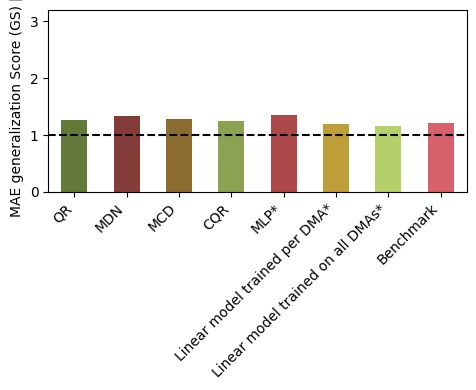

In [29]:


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharex=True, sharey=True)
# axs = ax.flatten()
# colors_gen = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
# colors_gen[-1] = 'tab:purple'


# mean_gen = df_mae_gen_1d.mean()
# mean_gen['Average'] = mean_gen.mean()
# ax.bar(mean_gen.index, df_mae_gen_1d['Average'], color='tab:blue')
df_mae_gen_1d['Average'].plot.bar(ax=ax, color=colors_gen)

ax.axhline(1, color='black', linestyle='--')
# ax.set_title(G, fontsize=10)
# ax.legend()
# ax.grid()
# rotate the xticks
ax.set_ylim(0,3.2)
ax.set_ylabel('MAE generalization Score (GS) [-]')
ax.set_xticklabels(df_mae_gen_1d.index, rotation=45, ha='right', fontsize=10)



fig.tight_layout()




In [ ]:
LD_per_dma_results_test_pt.index = LD_all_dmas_results_test_pt.index


In [30]:
# combine the five point prediction models into one dataframe
modelnames_pt = ['QR', 'MDN', 'MCD', 'CQR', 'MLP*', 'Linear model trained per DMA*', 'Linear model trained on all DMAs*','Benchmark Model',]

df_test_pt_mae = pd.concat([QR_result_test_pt.loc['MAE'], 
                            MDN_result_test_pt.loc['MAE'], 
                            mcd_test_pt.loc['MAE'], 
                            cqr_test_pt.loc['MAE'],
                            MLP_results_test_pt.loc['MAE'],
                            LD_per_dma_results_test_pt.loc['MAE'],
                            LD_all_dmas_results_test_pt.loc['MAE'],
                            naive_test_pt.loc['MAE'],
], axis=1).T
df_test_pt_mae.index = modelnames_pt

df_test_pt_minae = pd.concat([QR_result_test_pt.loc['Lowest AE'],
                            MDN_result_test_pt.loc['Lowest AE'],
                            mcd_test_pt.loc['Lowest AE'],
                            cqr_test_pt.loc['Lowest AE'],
                            MLP_results_test_pt.loc['Lowest AE'],
                            LD_per_dma_results_test_pt.loc['Lowest AE'],
                            LD_all_dmas_results_test_pt.loc['Lowest AE'],
], axis=1).T

df_test_pt_minae.index = modelnames_pt[:-1]

df_test_pt_maxae = pd.concat([QR_result_test_pt.loc['Highest AE'],
                            MDN_result_test_pt.loc['Highest AE'],
                            mcd_test_pt.loc['Highest AE'],
                            cqr_test_pt.loc['Highest AE'],
                            MLP_results_test_pt.loc['Highest AE'],
                            LD_per_dma_results_test_pt.loc['Highest AE'],
                            LD_all_dmas_results_test_pt.loc['Highest AE'],
], axis=1).T

df_test_pt_maxae.index = modelnames_pt[:-1]

df_test_pt_medianae = pd.concat([QR_result_test_pt.loc['Median AE'],
                            MDN_result_test_pt.loc['Median AE'],
                            mcd_test_pt.loc['Median AE'],
                            cqr_test_pt.loc['Median AE'],
                            MLP_results_test_pt.loc['Median AE'],
                            LD_per_dma_results_test_pt.loc['Median AE'],
                            LD_all_dmas_results_test_pt.loc['Median AE'],
], axis=1).T

df_test_pt_medianae.index = modelnames_pt[:-1]

df_test_pt_rmae = pd.concat([QR_result_test_pt.loc['RMAE'], 
                            MDN_result_test_pt.loc['RMAE'], 
                            mcd_test_pt.loc['RMAE'], 
                            cqr_test_pt.loc['RMAE'],
                            MLP_results_test_pt.loc['RMAE'],
                            LD_per_dma_results_test_pt.loc['RMAE'],
                            LD_all_dmas_results_test_pt.loc['RMAE']], axis=1).T

df_test_pt_rmae.index = modelnames_pt[:-1]

df_test_pt_rminae = pd.concat([QR_result_test_pt.loc['Lowest RAE'],
                            MDN_result_test_pt.loc['Lowest RAE'],
                            mcd_test_pt.loc['Lowest RAE'],
                            cqr_test_pt.loc['Lowest RAE'],
                            MLP_results_test_pt.loc['Lowest RAE'],
                            LD_per_dma_results_test_pt.loc['Lowest RAE'],
                            LD_all_dmas_results_test_pt.loc['Lowest RAE'],
], axis=1).T

df_test_pt_rminae.index = modelnames_pt[:-1]

df_test_pt_rmaxae = pd.concat([QR_result_test_pt.loc['Highest RAE'],
                            MDN_result_test_pt.loc['Highest RAE'],
                            mcd_test_pt.loc['Highest RAE'],
                            cqr_test_pt.loc['Highest RAE'],
                            MLP_results_test_pt.loc['Highest RAE'],
                            LD_per_dma_results_test_pt.loc['Highest RAE'],
                            LD_all_dmas_results_test_pt.loc['Highest RAE'],
], axis=1).T

df_test_pt_rmaxae.index = modelnames_pt[:-1]

df_test_pt_rmedianae = pd.concat([QR_result_test_pt.loc['Median RAE'],
                            MDN_result_test_pt.loc['Median RAE'],
                            mcd_test_pt.loc['Median RAE'],
                            cqr_test_pt.loc['Median RAE'],
                            MLP_results_test_pt.loc['Median RAE'],
                            LD_per_dma_results_test_pt.loc['Median RAE'],
                            LD_all_dmas_results_test_pt.loc['Median RAE'],
], axis=1).T

df_test_pt_rmedianae.index = modelnames_pt[:-1]

                            
df_test_pt_mape = pd.concat([QR_result_test_pt.loc['MAPE'], 
                            MDN_result_test_pt.loc['MAPE'], 
                            mcd_test_pt.loc['MAPE'], 
                            cqr_test_pt.loc['MAPE'],
                            MLP_results_test_pt.loc['MAPE'],
                            LD_per_dma_results_test_pt.loc['MAPE'],
                            LD_all_dmas_results_test_pt.loc['MAPE'],
                            naive_test_pt.loc['MAPE'],
], axis=1).T

df_test_pt_mape.index = modelnames_pt

df_test_pt_minape = pd.concat([QR_result_test_pt.loc['Lowest APE'],
                            MDN_result_test_pt.loc['Lowest APE'],
                            mcd_test_pt.loc['Lowest APE'],
                            cqr_test_pt.loc['Lowest APE'],
                            MLP_results_test_pt.loc['Lowest APE'],
                            LD_per_dma_results_test_pt.loc['Lowest APE'],
                            LD_all_dmas_results_test_pt.loc['Lowest APE'],
], axis=1).T

df_test_pt_mape.index = modelnames_pt

df_test_pt_maxape = pd.concat([QR_result_test_pt.loc['Highest APE'],
                            MDN_result_test_pt.loc['Highest APE'],
                            mcd_test_pt.loc['Highest APE'],
                            cqr_test_pt.loc['Highest APE'],
                            MLP_results_test_pt.loc['Highest APE'],
                            LD_per_dma_results_test_pt.loc['Highest APE'],
                            LD_all_dmas_results_test_pt.loc['Highest APE'],
], axis=1).T

df_test_pt_maxape.index = modelnames_pt[:-1]

df_test_pt_medianape = pd.concat([QR_result_test_pt.loc['Median APE'],
                            MDN_result_test_pt.loc['Median APE'],
                            mcd_test_pt.loc['Median APE'],
                            cqr_test_pt.loc['Median APE'],
                            MLP_results_test_pt.loc['Median APE'],
                            LD_per_dma_results_test_pt.loc['Median APE'],
                            LD_all_dmas_results_test_pt.loc['Median APE'],
], axis=1).T

df_test_pt_medianape.index = modelnames_pt[:-1]


# VAL DATA
df_val_pt_mae = pd.concat([QR_result_val_pt.loc['MAE'], 
                            MDN_result_val_pt.loc['MAE'], 
                            mcd_val_pt.loc['MAE'], 
                            cqr_val_pt.loc['MAE'],
                            MLP_results_val_pt.loc['MAE'],
                            LD_per_dma_results_val_pt.loc['MAE'],
                            LD_all_dmas_results_val_pt.loc['MAE'],
                            naive_val_pt.loc['MAE']], axis=1).T

df_val_pt_rmae = pd.concat([QR_result_val_pt.loc['RMAE'], 
                            MDN_result_val_pt.loc['RMAE'], 
                            mcd_val_pt.loc['RMAE'], 
                            cqr_val_pt.loc['RMAE'],
                            MLP_results_val_pt.loc['RMAE'],
                            LD_per_dma_results_val_pt.loc['RMAE'],
                            LD_all_dmas_results_val_pt.loc['RMAE']], axis=1).T

df_val_pt_rmae.index = modelnames_pt[:-1]
                            

df_val_pt_mape = pd.concat([QR_result_val_pt.loc['MAPE'], 
                            MDN_result_val_pt.loc['MAPE'], 
                            mcd_val_pt.loc['MAPE'], 
                            cqr_val_pt.loc['MAPE'],
                            MLP_results_val_pt.loc['MAPE'],
                            LD_per_dma_results_val_pt.loc['MAPE'],
                            LD_all_dmas_results_val_pt.loc['MAPE'],
                            naive_val_pt.loc['MAPE']], axis=1).T


df_val_pt_mae.index = modelnames_pt
# df_val_pt_rmae.index = modelnames_pt
df_val_pt_mape.index = modelnames_pt



In [62]:
print('MAPE [%] point forecasts of all probabilistic models on test set')
pretty_display_df(df_test_pt_mape, sort_by='Average', print_latex=False, print_display=True, name='MAPE [%] point forecasts of all probabilistic models on test set')
print()

print('RMAE [-] point forecasts of all probabilistic models on test set')
pretty_display_df(df_test_pt_rmae, sort_by='Average', print_latex=False, print_display=True, name='RMAE [-] point forecasts of probabilistic models on test set')
print()

print('MAE [L/s] point forecasts of all  probabilistic models on test set')
pretty_display_df(df_test_pt_mae.loc[df_test_pt_mape.sort_values('Average').index, DMAs], print_latex=False, print_display=True, name='MAE [L/s] point forecasts of all  probabilistic models on test set')
print()

print('MAPE [%] point forecasts of all probabilistic models on validation set')
pretty_display_df(df_val_pt_mape, sort_by='Average', print_latex=False, print_display=True, name='MAPE [%] point forecasts of all probabilistic models on validation set')
print()

print('RMAE [-] point forecasts of all probabilistic models on validation set')
pretty_display_df(df_val_pt_rmae, sort_by='Average', print_latex=False, print_display=True, name='RMAE [-] point forecasts of probabilistic models on validation set')
print()

print('MAE [L/s] point forecasts of all  probabilistic models on validation set')
pretty_display_df(df_val_pt_mae.loc[df_val_pt_mape.sort_values('Average').index, DMAs], print_latex=False, print_display=True, name='MAE [L/s] point forecasts of all  probabilistic models on validation set')
print()

print('GR [-] point forecasts of all probabilistic models')
pretty_display_df(df_mae_gen_1d, sort_by='Average', print_latex=False, print_display=True, name='GR [-] point forecasts of all probabilistic models')


MAPE [%] point forecasts of all probabilistic models on test set


,A,B,C,D,E,F,G,H,I,J,Average
MCD,14.20,4.65,9.46,6.98,1.77,8.97,3.70,4.38,5.90,4.65,6.46
MLP*,13.38,4.90,9.70,7.04,1.89,8.80,4.01,4.50,6.19,4.64,6.51
MDN,13.37,4.72,9.90,7.16,1.90,8.86,3.78,4.87,6.23,4.71,6.55
Linear model trained per DMA*,13.98,4.87,9.30,7.54,2.33,8.96,3.91,4.95,6.08,5.20,6.71
Linear model trained on all DMAs*,15.15,4.81,9.37,7.30,2.25,8.92,3.53,4.69,6.13,5.26,6.74
QR,14.07,5.06,9.85,7.25,2.34,8.90,3.96,5.24,6.15,4.77,6.76
CQR,14.30,5.24,10.10,7.41,2.50,9.09,4.22,5.35,6.21,4.95,6.94
Benchmark Model,18.49,6.65,12.64,8.02,2.06,9.71,4.00,4.80,7.08,5.54,7.90



RMAE [-] point forecasts of all probabilistic models on test set


,A,B,C,D,E,F,G,H,I,J,Average
MCD,0.80,0.70,0.72,0.87,0.87,0.92,0.91,0.93,0.84,0.86,0.84
MLP*,0.80,0.73,0.74,0.88,0.91,0.90,1.00,0.95,0.89,0.86,0.87
MDN,0.77,0.71,0.75,0.89,0.92,0.92,0.96,1.06,0.91,0.88,0.88
Linear model trained on all DMAs*,0.84,0.72,0.73,0.92,1.10,0.92,0.89,0.98,0.87,0.98,0.90
Linear model trained per DMA*,0.80,0.72,0.72,0.94,1.12,0.93,0.98,1.03,0.87,0.96,0.91
QR,0.81,0.75,0.76,0.91,1.13,0.92,0.98,1.11,0.89,0.89,0.92
CQR,0.83,0.78,0.78,0.93,1.20,0.94,1.04,1.09,0.89,0.92,0.94



MAE [m/s] point forecasts of all  probabilistic models on test set


,A,B,C,D,E,F,G,H,I,J
MCD,1.02,0.48,0.38,2.03,1.44,0.79,1.02,0.98,1.37,1.23
MLP*,1.01,0.50,0.39,2.04,1.52,0.78,1.11,1.00,1.45,1.23
MDN,0.99,0.49,0.39,2.08,1.54,0.79,1.07,1.12,1.47,1.26
Linear model trained per DMA*,1.02,0.50,0.38,2.20,1.87,0.80,1.09,1.08,1.41,1.37
Linear model trained on all DMAs*,1.07,0.50,0.39,2.14,1.84,0.79,0.99,1.03,1.40,1.40
QR,1.03,0.52,0.40,2.12,1.89,0.79,1.10,1.17,1.45,1.27
CQR,1.05,0.54,0.41,2.15,1.99,0.81,1.16,1.15,1.44,1.31
Benchmark Model,1.27,0.69,0.53,2.33,1.67,0.86,1.11,1.06,1.62,1.43



MAPE [%] point forecasts of all probabilistic models on validation set


,A,B,C,D,E,F,G,H,I,J,Average
MLP*,11.54,2.71,6.29,5.65,1.54,9.04,3.26,3.11,5.67,4.21,5.30
MDN,11.15,2.92,6.33,5.79,1.55,9.06,3.43,3.13,5.64,4.18,5.32
MCD,11.99,2.86,6.31,5.69,1.49,9.17,3.27,3.08,5.89,4.24,5.40
QR,11.48,3.11,6.80,5.77,2.20,9.09,3.85,4.14,5.74,4.35,5.65
CQR,11.55,3.26,7.07,5.89,2.37,9.24,4.07,4.40,5.88,4.48,5.82
Linear model trained per DMA*,11.17,3.44,7.19,6.00,2.33,9.41,4.03,4.08,6.40,4.74,5.88
Linear model trained on all DMAs*,12.54,3.29,7.12,5.76,2.36,9.24,3.98,4.00,6.55,4.83,5.97
Benchmark Model,14.44,3.73,7.88,6.61,1.96,11.09,4.41,5.60,6.46,4.81,6.70



RMAE [-] point forecasts of all probabilistic models on validation set


,A,B,C,D,E,F,G,H,I,J,Average
MLP*,0.81,0.68,0.79,0.85,0.79,0.81,0.73,0.59,0.88,0.88,0.78
MCD,0.81,0.72,0.78,0.86,0.78,0.82,0.74,0.58,0.91,0.88,0.79
MDN,0.78,0.74,0.81,0.88,0.80,0.81,0.77,0.59,0.88,0.87,0.79
QR,0.79,0.78,0.85,0.87,1.11,0.82,0.87,0.77,0.90,0.91,0.87
CQR,0.81,0.81,0.87,0.88,1.19,0.83,0.91,0.81,0.92,0.94,0.90
Linear model trained per DMA*,0.77,0.87,0.89,0.92,1.18,0.84,0.92,0.76,0.99,0.99,0.91
Linear model trained on all DMAs*,0.84,0.85,0.90,0.88,1.22,0.82,0.91,0.75,1.01,1.01,0.92



MAE [m/s] point forecasts of all  probabilistic models on validation set


,A,B,C,D,E,F,G,H,I,J
MLP*,0.86,0.25,0.31,1.79,1.20,0.71,0.78,0.62,1.10,1.08
MDN,0.84,0.27,0.32,1.85,1.21,0.71,0.82,0.63,1.10,1.08
MCD,0.87,0.26,0.31,1.82,1.18,0.72,0.79,0.62,1.14,1.09
QR,0.85,0.28,0.34,1.85,1.68,0.72,0.93,0.82,1.12,1.12
CQR,0.87,0.29,0.35,1.87,1.81,0.73,0.97,0.85,1.14,1.16
Linear model trained per DMA*,0.82,0.31,0.35,1.94,1.79,0.74,0.98,0.81,1.23,1.22
Linear model trained on all DMAs*,0.90,0.31,0.36,1.87,1.85,0.72,0.97,0.80,1.26,1.24
Benchmark Model,1.07,0.36,0.40,2.11,1.51,0.88,1.06,1.06,1.24,1.23



GR [-] point forecasts of all probabilistic models


,A,B,C,D,E,F,G,H,I,J,Average
Linear model trained on all DMAs*,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear model trained per DMA*,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
CQR,1.22,1.82,1.18,1.15,1.10,1.10,1.20,1.35,1.26,1.14,1.25
QR,1.21,1.85,1.20,1.15,1.12,1.10,1.18,1.43,1.30,1.14,1.27
MCD,1.18,1.84,1.22,1.11,1.23,1.10,1.29,1.58,1.20,1.13,1.29
MDN,1.18,1.84,1.22,1.13,1.27,1.11,1.29,1.79,1.34,1.17,1.33
MLP*,1.17,2.04,1.25,1.14,1.27,1.09,1.43,1.61,1.32,1.14,1.35


,A,B,C,D,E,F,G,H,I,J,Average
Linear model trained on all DMAs*,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear model trained per DMA*,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
CQR,1.22,1.82,1.18,1.15,1.10,1.10,1.20,1.35,1.26,1.14,1.25
QR,1.21,1.85,1.20,1.15,1.12,1.10,1.18,1.43,1.30,1.14,1.27
MCD,1.18,1.84,1.22,1.11,1.23,1.10,1.29,1.58,1.20,1.13,1.29
MDN,1.18,1.84,1.22,1.13,1.27,1.11,1.29,1.79,1.34,1.17,1.33
MLP*,1.17,2.04,1.25,1.14,1.27,1.09,1.43,1.61,1.32,1.14,1.35


In [63]:
# print('MAPE [%] point forecasts of all probabilistic models on test set')
pretty_display_df(df_test_pt_mape, sort_by='Average', print_latex=True, print_display=False, name='MAPE [\%] point forecasts of all probabilistic models on test set')
print()

# print('RMAE [-] point forecasts of all probabilistic models on test set')
pretty_display_df(df_test_pt_rmae, sort_by='Average', print_latex=True, print_display=False, name='RMAE [-] point forecasts of probabilistic models on test set')
print()

# print('MAE [L/s] point forecasts of all  probabilistic models on test set')
pretty_display_df(df_test_pt_mae.loc[df_test_pt_mape.sort_values('Average').index, DMAs], print_latex=True, print_display=False, name='MAE [L/s] point forecasts of all  probabilistic models on test set')
print()

# print('MAPE [%] point forecasts of all probabilistic models on validation set')
pretty_display_df(df_val_pt_mape, sort_by='Average', print_latex=True, print_display=False, name='MAPE [\%] point forecasts of all probabilistic models on validation set')
print()

# print('RMAE [-] point forecasts of all probabilistic models on validation set')
pretty_display_df(df_val_pt_rmae, sort_by='Average', print_latex=True, print_display=False, name='RMAE [-] point forecasts of probabilistic models on validation set')
print()

# print('MAE [L/s] point forecasts of all  probabilistic models on validation set')
pretty_display_df(df_val_pt_mae.loc[df_val_pt_mape.sort_values('Average').index, DMAs], print_latex=True, print_display=False, name='MAE [L/s] point forecasts of all  probabilistic models on validation set')
print()


print('GR [-] point forecasts of all probabilistic models')
pretty_display_df(df_mae_gen_1d, sort_by='Average', print_latex=True, print_display=False, name='GR [-] point forecasts of all probabilistic models')


\begin{table}[H]
\caption{MAPE [\%] point forecasts of all probabilistic models on test set}
\label{table: MAPE [\%] point forecasts of all probabilistic models on test set}
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{llllllllllll}
\toprule
 & A & B & C & D & E & F & G & H & I & J & Average \\
\midrule
MCD & 14.20 & \cellcolor{lightgreen} \textbf{4.65} & 9.46 & \cellcolor{lightgreen} \textbf{6.98} & \cellcolor{lightgreen} \textbf{1.77} & 8.97 & 3.70 & \cellcolor{lightgreen} \textbf{4.38} & \cellcolor{lightgreen} \textbf{5.90} & 4.65 & \cellcolor{lightgreen} \textbf{6.46} \\
MLP* & 13.38 & 4.90 & 9.70 & 7.04 & 1.89 & \cellcolor{lightgreen} \textbf{8.80} & 4.01 & 4.50 & 6.19 & \cellcolor{lightgreen} \textbf{4.64} & 6.51 \\
MDN & \cellcolor{lightgreen} \textbf{13.37} & 4.72 & 9.90 & 7.16 & 1.90 & 8.86 & 3.78 & 4.87 & 6.23 & 4.71 & 6.55 \\
Linear model trained per DMA* & 13.98 & 4.87 & \cellcolor{lightgreen} \textbf{9.30} & 7.54 & 2.33 & 8.96 & 3.91 & 4.95 & 6.08 & 5.20 & 6.71 \

,A,B,C,D,E,F,G,H,I,J,Average
Linear model trained on all DMAs*,1.19,1.62,1.08,1.15,0.99,1.09,1.02,1.29,1.11,1.12,1.17
Linear model trained per DMA*,1.24,1.59,1.08,1.13,1.04,1.08,1.12,1.35,1.14,1.12,1.19
Benchmark,1.19,1.90,1.33,1.10,1.10,0.98,1.05,1.00,1.30,1.16,1.21
CQR,1.22,1.82,1.18,1.15,1.10,1.10,1.20,1.35,1.26,1.14,1.25
QR,1.21,1.85,1.20,1.15,1.12,1.10,1.18,1.43,1.30,1.14,1.27
MCD,1.18,1.84,1.22,1.11,1.23,1.10,1.29,1.58,1.20,1.13,1.29
MDN,1.18,1.84,1.22,1.13,1.27,1.11,1.29,1.79,1.34,1.17,1.33
MLP*,1.17,2.04,1.25,1.14,1.27,1.09,1.43,1.61,1.32,1.14,1.35


In [53]:
# # print all the min and max errors

# print('RMAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmae.sort_values('Average'), print_latex=False, print_display=True)

# print('RMaxAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmaxae.sort_values('Average'), print_latex=False, print_display=True)

# print('RMedianAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmedianae.sort_values('Average'), print_latex=False, print_display=True)

# print('MAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_mape.sort_values('Average'), sort_by='Average', print_latex=False, print_display=True)

# print('MaxAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_maxape.sort_values('Average'), print_latex=False, print_display=True)

# print('MedianAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_medianape.sort_values('Average'), print_latex=False, print_display=True)

# print('MAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_mae.loc[df_test_pt_rmae.index, DMAs], print_latex=False, print_display=True)

# print('MaxAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_maxae.loc[df_test_pt_rmaxae.index, DMAs], print_latex=False, print_display=True)

# print('MedianAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_medianae.loc[df_test_pt_rmedianae.index, DMAs], print_latex=False, print_display=True)


# # print all the min and max errors
# print('MAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_mae.loc[df_test_pt_rmae.index, DMAs], print_latex=True, print_display=False)

# print('MaxAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_maxae.loc[df_test_pt_rmaxae.index, DMAs], print_latex=True, print_display=False)

# print('MedianAE [L/s] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_medianae.loc[df_test_pt_rmedianae.index, DMAs], print_latex=True, print_display=False)

# print('RMAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmae.sort_values('Average'), print_latex=True, print_display=False)

# print('MaxRAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmaxae.sort_values('Average'), print_latex=True, print_display=False)

# print('MedianRAE [-] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_rmedianae.sort_values('Average'), print_latex=True, print_display=False)

# print('MAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_mape.sort_values('Average'), sort_by='Average', print_latex=True, print_display=False)

# print('MaxAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_maxape.sort_values('Average'), print_latex=True, print_display=False)

# print('MedianAPE [%] errors point forecasts of probablistic models')
# pretty_display_df(df_test_pt_medianape.sort_values('Average'), print_latex=True, print_display=False)



RMAE [-] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
MCD,0.80,0.70,0.72,0.87,0.87,0.92,0.91,0.93,0.84,0.86,0.84
MLP*,0.80,0.73,0.74,0.88,0.91,0.90,1.00,0.95,0.89,0.86,0.87
MDN,0.77,0.71,0.75,0.89,0.92,0.92,0.96,1.06,0.91,0.88,0.88
Linear model trained on all DMAs*,0.84,0.72,0.73,0.92,1.10,0.92,0.89,0.98,0.87,0.98,0.90
Linear model trained per DMA*,0.80,0.72,0.72,0.94,1.12,0.93,0.98,1.03,0.87,0.96,0.91
QR,0.81,0.75,0.76,0.91,1.13,0.92,0.98,1.11,0.89,0.89,0.92
CQR,0.83,0.78,0.78,0.93,1.20,0.94,1.04,1.09,0.89,0.92,0.94


RMaxAE [-] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
QR,13.48,9.73,9.37,5.08,23.92,8.30,7.94,9.42,12.09,8.78,10.81
MCD,13.11,9.08,10.36,4.65,24.41,8.55,7.66,9.91,11.95,8.70,10.84
Linear model trained on all DMAs*,13.28,10.11,10.41,6.25,24.58,8.75,8.16,9.39,11.22,8.52,11.07
MLP*,13.61,9.61,10.26,4.97,24.77,8.48,8.61,10.25,12.24,8.77,11.16
MDN,13.39,9.81,10.81,4.96,24.86,8.13,8.12,10.79,12.56,8.66,11.21
CQR,13.65,10.10,9.79,5.48,23.60,8.33,8.87,11.01,12.26,9.14,11.22
Linear model trained per DMA*,13.85,10.02,10.87,4.59,24.15,8.82,8.52,9.78,11.68,10.30,11.26


RMedianAE [-] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
MCD,0.56,0.43,0.47,0.73,0.61,0.72,0.71,0.69,0.62,0.68,0.62
MLP*,0.54,0.46,0.50,0.74,0.68,0.71,0.78,0.71,0.65,0.68,0.65
MDN,0.55,0.43,0.52,0.75,0.68,0.73,0.72,0.77,0.65,0.69,0.65
Linear model trained on all DMAs*,0.61,0.44,0.47,0.77,0.75,0.73,0.66,0.72,0.64,0.75,0.66
Linear model trained per DMA*,0.57,0.46,0.48,0.78,0.85,0.74,0.75,0.77,0.63,0.72,0.68
QR,0.58,0.50,0.51,0.77,0.87,0.72,0.76,0.85,0.63,0.70,0.69
CQR,0.59,0.51,0.52,0.78,0.92,0.74,0.82,0.85,0.64,0.72,0.71


MAPE [%] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
MCD,14.20,4.65,9.46,6.98,1.77,8.97,3.70,4.38,5.90,4.65,6.46
MLP*,13.38,4.90,9.70,7.04,1.89,8.80,4.01,4.50,6.19,4.64,6.51
MDN,13.37,4.72,9.90,7.16,1.90,8.86,3.78,4.87,6.23,4.71,6.55
Linear model trained per DMA*,13.98,4.87,9.30,7.54,2.33,8.96,3.91,4.95,6.08,5.20,6.71
Linear model trained on all DMAs*,15.15,4.81,9.37,7.30,2.25,8.92,3.53,4.69,6.13,5.26,6.74
QR,14.07,5.06,9.85,7.25,2.34,8.90,3.96,5.24,6.15,4.77,6.76
CQR,14.30,5.24,10.10,7.41,2.50,9.09,4.22,5.35,6.21,4.95,6.94
Benchmark Model,18.49,6.65,12.64,8.02,2.06,9.71,4.00,4.80,7.08,5.54,7.90


MaxAPE [%] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
QR,279.98,60.08,124.71,67.33,89.86,144.87,33.50,54.20,46.95,36.98,93.85
MLP*,281.78,66.89,124.74,63.06,93.07,135.11,35.95,60.30,49.06,38.52,94.85
MCD,291.47,61.64,125.93,69.22,91.72,146.02,33.87,55.46,46.41,36.96,95.87
CQR,274.25,64.09,132.19,75.85,88.65,142.21,37.41,62.27,47.58,37.51,96.20
MDN,276.78,63.91,137.44,67.66,93.39,138.83,37.35,60.45,54.75,37.31,96.79
Linear model trained on all DMAs*,357.22,71.61,126.60,69.64,92.35,131.42,29.97,55.87,44.65,45.42,102.48
Linear model trained per DMA*,438.98,69.66,132.14,63.65,90.73,137.19,31.26,56.10,45.75,60.03,112.55


MedianAPE [%] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J,Average
MCD,9.41,3.09,7.20,5.46,1.33,7.06,2.98,3.50,4.64,3.73,4.84
MLP*,9.46,3.34,7.43,5.49,1.48,6.97,3.30,3.60,4.90,3.75,4.97
MDN,9.45,3.13,7.84,5.56,1.48,7.14,3.05,4.01,4.94,3.79,5.04
Linear model trained on all DMAs*,10.44,3.19,6.95,5.74,1.64,7.18,2.83,3.63,4.82,4.14,5.06
Linear model trained per DMA*,9.79,3.35,7.07,5.83,1.82,7.24,3.20,3.89,4.78,3.94,5.09
QR,9.96,3.60,7.53,5.74,1.88,7.11,3.23,4.33,4.80,3.88,5.21
CQR,10.19,3.73,7.67,5.77,1.97,7.25,3.43,4.23,4.86,3.99,5.31


MAE [m/s] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J
QR,1.03,0.52,0.40,2.12,1.89,0.79,1.10,1.17,1.45,1.27
MDN,0.99,0.49,0.39,2.08,1.54,0.79,1.07,1.12,1.47,1.26
MCD,1.02,0.48,0.38,2.03,1.44,0.79,1.02,0.98,1.37,1.23
CQR,1.05,0.54,0.41,2.15,1.99,0.81,1.16,1.15,1.44,1.31
MLP*,1.01,0.50,0.39,2.04,1.52,0.78,1.11,1.00,1.45,1.23
Linear model trained per DMA*,1.02,0.50,0.38,2.20,1.87,0.80,1.09,1.08,1.41,1.37
Linear model trained on all DMAs*,1.07,0.50,0.39,2.14,1.84,0.79,0.99,1.03,1.40,1.40


MaxAE [m/s] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J
QR,17.14,6.71,4.95,11.81,39.85,7.13,8.84,9.95,19.60,12.54
MDN,17.02,6.77,5.71,11.53,41.42,6.98,9.04,11.40,20.35,12.36
MCD,16.67,6.27,5.47,10.82,40.68,7.35,8.54,10.47,19.37,12.42
CQR,17.35,6.97,5.17,12.74,39.32,7.16,9.88,11.64,19.86,13.05
MLP*,17.30,6.63,5.42,11.56,41.28,7.29,9.59,10.83,19.84,12.52
Linear model trained per DMA*,17.62,6.91,5.74,10.67,40.24,7.57,9.49,10.33,18.93,14.70
Linear model trained on all DMAs*,16.88,6.97,5.50,14.54,40.96,7.52,9.09,9.92,18.18,12.17


MedianAE [m/s] errors point forecasts of probablistic models


,A,B,C,D,E,F,G,H,I,J
QR,0.74,0.34,0.27,1.79,1.44,0.62,0.85,0.90,1.03,1.00
MDN,0.70,0.30,0.28,1.75,1.13,0.63,0.80,0.82,1.05,0.98
MCD,0.71,0.29,0.25,1.71,1.02,0.62,0.79,0.72,1.00,0.97
CQR,0.76,0.35,0.28,1.81,1.53,0.64,0.91,0.90,1.04,1.03
MLP*,0.69,0.32,0.26,1.73,1.14,0.61,0.87,0.75,1.05,0.97
Linear model trained per DMA*,0.72,0.32,0.25,1.83,1.41,0.64,0.84,0.82,1.03,1.02
Linear model trained on all DMAs*,0.78,0.30,0.25,1.79,1.26,0.63,0.74,0.76,1.04,1.07


MAE [m/s] errors point forecasts of probablistic models
\begin{tabular}{lllllllllll}
 & A & B & C & D & E & F & G & H & I & J \\
QR & 1.03 & 0.52 & 0.40 & 2.12 & 1.89 & 0.79 & 1.10 & \background-color#ffd3d3 \font-weightbold 1.17 & 1.45 & 1.27 \\
MDN & \background-color#d9ecd9 \font-weightbold 0.99 & 0.49 & 0.39 & 2.08 & 1.54 & 0.79 & 1.07 & 1.12 & \background-color#ffd3d3 \font-weightbold 1.47 & 1.26 \\
MCD & 1.02 & \background-color#d9ecd9 \font-weightbold 0.48 & \background-color#d9ecd9 \font-weightbold 0.38 & \background-color#d9ecd9 \font-weightbold 2.03 & \background-color#d9ecd9 \font-weightbold 1.44 & 0.79 & 1.02 & \background-color#d9ecd9 \font-weightbold 0.98 & \background-color#d9ecd9 \font-weightbold 1.37 & \background-color#d9ecd9 \font-weightbold 1.23 \\
CQR & 1.05 & \background-color#ffd3d3 \font-weightbold 0.54 & \background-color#ffd3d3 \font-weightbold 0.41 & 2.15 & \background-color#ffd3d3 \font-weightbold 1.99 & \background-color#ffd3d3 \font-weightbold 0.81 & \back

In [ ]:
colors = colors_gen


/tmp/ipykernel_415291/4020205499.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/4020205499.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/4020205499.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/4020205499.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/4020205499.py:25: User

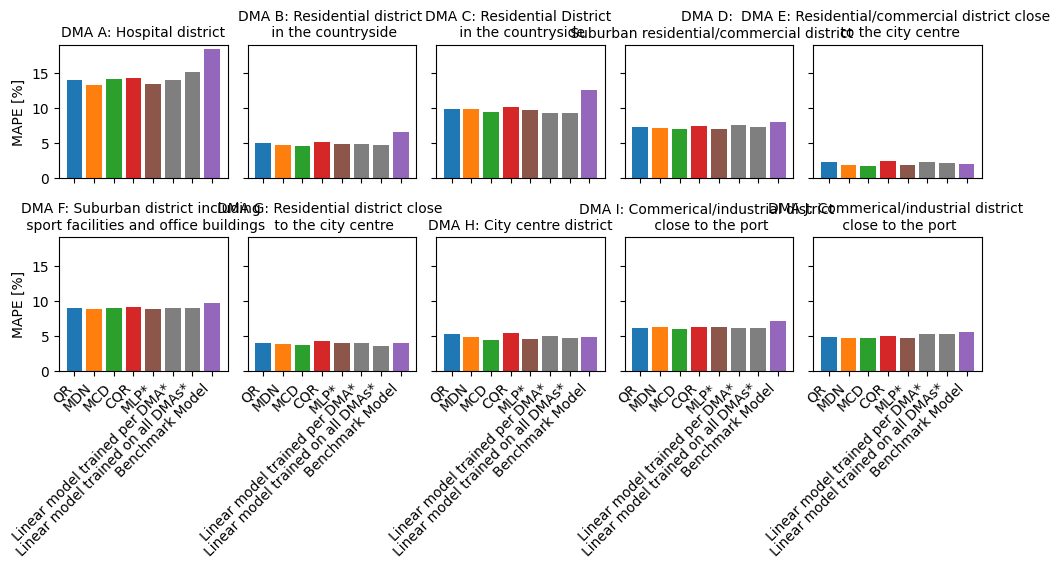

In [54]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']

for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    ax.bar(mape.index, mape, color=colors)

    ax.set_ylim(0, 19)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('MAPE [%]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# add legend in th ebottom
from matplotlib.lines import Line2D

fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)



/tmp/ipykernel_415291/2070226559.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2070226559.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2070226559.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2070226559.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2070226559.py:27: User

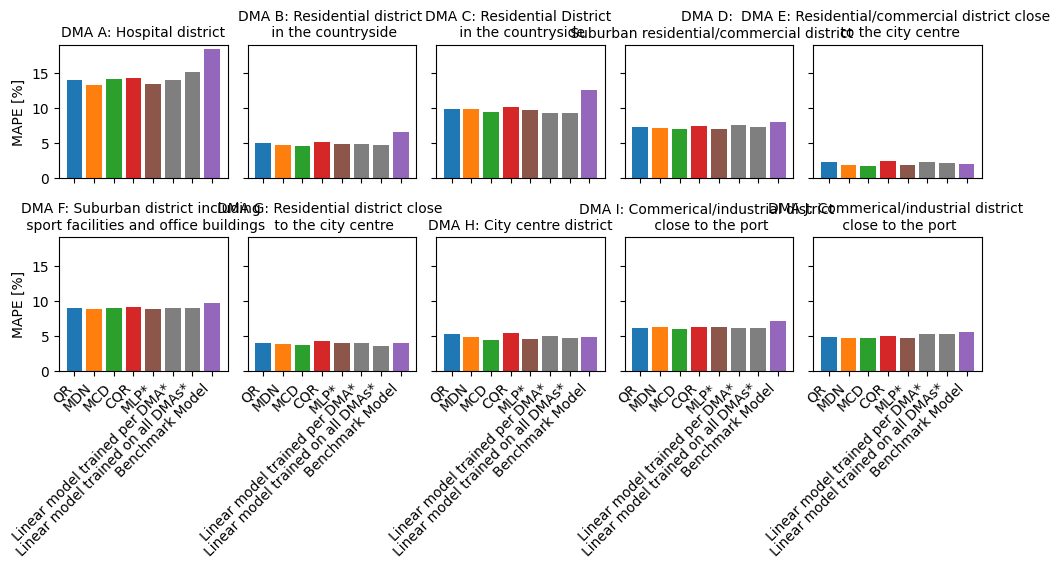

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
# colors_gen[-1] = 'tab:purple'

for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    ax.bar(mape.index, mape, color=colors)

    ax.set_ylim(0, 19)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('MAPE [%]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# add legend in th ebottom
from matplotlib.lines import Line2D

# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)




/tmp/ipykernel_415291/2236874469.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2236874469.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2236874469.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2236874469.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/2236874469.py:38: User

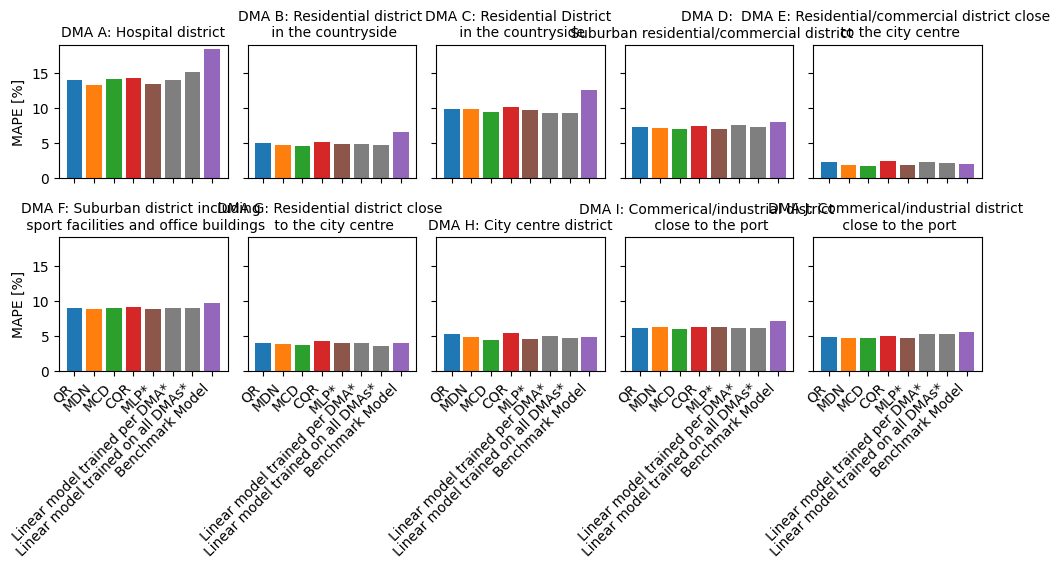

In [56]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
# colors_gen[-1] = 'tab:purple'

for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    ax.bar(mape.index, mape, color=colors)


    # ax.axhline(1, color='black', linestyle='--')
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    ax.set_ylim(0, 19)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('MAPE [%]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)

# add legend in th ebottom
from matplotlib.lines import Line2D

# Define legend handles with appropriate colors
# legend_handles = [Line2D([0], [0], color=colors[i], lw=4) for i in range(len(models_bar))] + [Line2D([0], [0], color='black', lw=2, linestyle='--')]

# # Add legend to the figure
# fig.legend(handles=legend_handles, labels=models_bar + ['Perfect Generalization'], loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))

# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_test_pt_mape.iloc[:,i]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
# add legend in th ebottom
# fig.subplots_adjust(bottom=-0.25, top=0.95)
# add more spacing between the subplots

# plt.subplots_adjust(wspace=0.5, hspace=0.9)

# make new graph just for the average results of the models



/tmp/ipykernel_415291/1786639197.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/1786639197.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/1786639197.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/1786639197.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)
/tmp/ipykernel_415291/1786639197.py:30: User

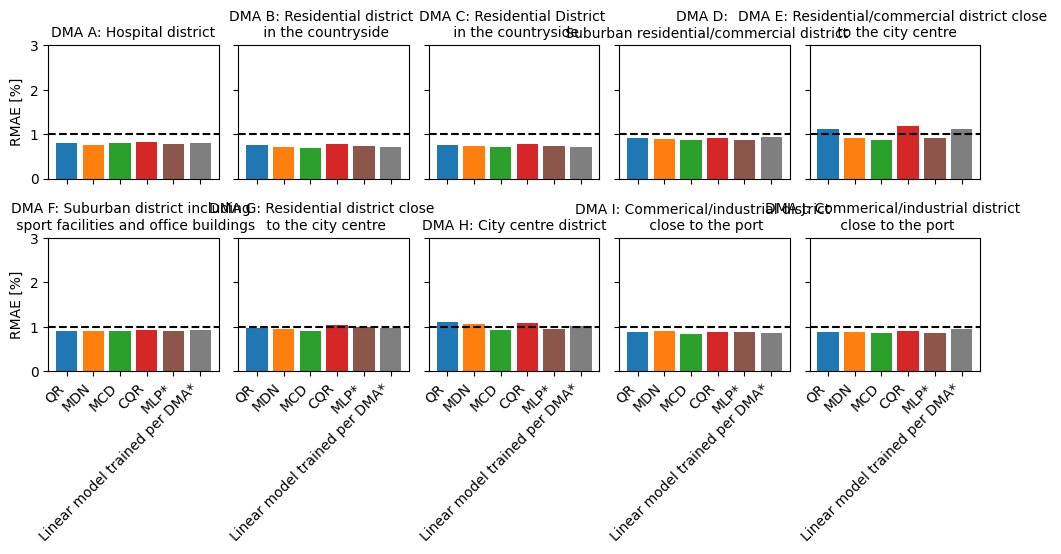

In [57]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10,4), sharex=True, sharey=True)
axs = ax.flatten()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:gray', 'tab:gray', 'tab:purple','tab:olive', 'tab:cyan']
# colors_gen[-1] = 'tab:purple'

for i, ax in enumerate(axs):

    mape = df_test_pt_rmae.iloc[:-1,i]
    ax.bar(mape.index, mape, color=colors)


    # ax.axhline(1, color='black', linestyle='--')
    # ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    # ax.legend()
    # ax.grid()
    ax.set_ylim(0, 3)
    # rotate the xticks
    if i == 0 or i == 5:
        ax.set_ylabel('RMAE [%]')
    ax.set_xticklabels([], rotation=45, ha='right', fontsize=10)
    ax.set_title(new_column_names_with_newlines[i], fontsize=10)
    ax.axhline(1, color='black', linestyle='--')

# tight layout that only changes the plot vertically
fig.tight_layout()
for i, ax in enumerate(axs):

    mape = df_test_pt_rmae.iloc[:,i]
    
    ax.set_xticklabels(mape.index, rotation=45, ha='right', fontsize=10)


